# Ranking Probabilistic Finite State Machines (PFSMs) in Swarm Intelligence Using Statistical Analysis

## Introduction

In this study, we aim to mimic expert behavior using AutoMoDe Chocolate. To create experts for each mission, we generate a sample of simulated robot behaviors using data from Hasselmann et al. The control software generated for the five missions -**XOR-Aggregation**, **Homing**, **Foraging**, **Shelter**, and **Directional Gate**- was developed with AutoMoDe Chocolate, and we selected the instance with the highest performance out of 200 executions. Each simulation follows the methodology presented by Hasselmann et al, including initial conditions and performance evaluations. The duration of each simulation is set at 15,000 steps. In this context, an expert is defined as a control software package (PFSM). We have 10 PFSMs for each mission.

This paper describes a comprehensive Python-based methodology that exploits several statistical tests and visualization techniques to robustly rank the PFSMs and then establish the expert for a specific mission. By integrating parametric and non-parametric analyses, this approach guarantees a nuanced assessment of PFSM performance under various conditions.

This analytical framework provides a systematic and statistically robust method for evaluating and ranking PFSMs within swarm intelligence contexts. By incorporating multiple statistical tests, effect size calculations, and aggregate ranking methodologies, it ensures a holistic assessment of PFSM performance. The inclusion of diverse visualization techniques further aids in the intuitive interpretation of results, facilitating informed decision-making in the design and selection of optimal PFSMs for autonomous agents.

**Note:** Ensure that all performance data CSV files (`performance_data_{mission}_{method}_{environment}.csv`) are correctly formatted and placed in the appropriate directory. The script is designed to run in environments that support Jupyter Notebook-style markdown and visualizations, such as JupyterLab or similar platforms.

## Table of Contents

1. [Dependencies and Environment Setup](#dependencies-and-environment-setup)
2. [Data Loading and Preprocessing](#data-loading-and-preprocessing)
3. [Descriptive Statistical Analysis](#descriptive-statistical-analysis)
4. [Normality and Homogeneity of Variances](#normality-and-homogeneity-of-variances)
5. [Inferential Statistical Tests](#inferential-statistical-tests)
    - [One-Way ANOVA](#one-way-anova)
    - [Kruskal-Wallis H-Test](#kruskal-wallis-h-test)
6. [Post-Hoc Analyses](#post-hoc-analyses)
    - [Tukey's Honestly Significant Difference (HSD) Test](#tukeys-honestly-significant-difference-hsd-test)
    - [Dunn's Test](#dunns-test)
7. [Effect Size Calculation](#effect-size-calculation)
8. [Visualization Techniques](#visualization-techniques)
    - [Boxplots](#boxplots)
    - [Violin Plots](#violin-plots)
    - [Heatmaps](#heatmaps)
    - [Line Plots](#line-plots)
9. [Ranking Methodology](#ranking-methodology)
10. [Results Summarization](#results-summarization)
11. [Main Analysis Pipeline](#main-analysis-pipeline)
12. [FSM Mapping Reference](#fsm-mapping-reference)

---



## Dependencies and Environment Setup

Before commencing the analysis, it is imperative to ensure that all requisite Python packages are installed and configured appropriately. The following code snippet automates the installation of any missing packages, thereby safeguarding against runtime errors due to absent dependencies.

**Explanation:**

- **`pkg_resources`**: Utilized to inspect the currently installed packages.
- **`subprocess`**: Facilitates the installation of missing packages via `pip`.
- **`required`**: A set encompassing all necessary packages for the analysis.
- The script ensures a prepared environment by installing any absent dependencies, thereby preventing interruptions during execution.


In [16]:
# Install required packages if they are not already installed
import sys
import subprocess
import pkg_resources

required = {
    'pandas',
    'numpy',
    'matplotlib',
    'seaborn',
    'scipy',
    'statsmodels',
    'pingouin'
}

installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    print(f"Installing missing packages: {missing}")
    # Implement pip as a subprocess:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', *missing])
else:
    print("All required packages are already installed.")

import sys
import subprocess
import pkg_resources
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
import pingouin as pg
import warnings
from functools import lru_cache
from IPython.display import display, Markdown

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plot aesthetics
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


All required packages are already installed.



---

## Data Loading and Preprocessing

Efficient data handling and preprocessing are foundational to accurate statistical analysis. The following functions streamline the process of loading and structuring performance data.

### Reading Performance Data

**Explanation:**

- **`@lru_cache`**: Decorator that caches the results of function calls, optimizing repeated data accesses.
- Constructs the filename dynamically based on `mission`, `method`, and `environment`.
- Reads the CSV file into a pandas DataFrame if it exists; otherwise, issues a warning.

### Extracting Performance Metrics

**Explanation:**

- Transforms the 'Performances' column, which contains semicolon-separated values, into individual performance records.
- Structures the data into a long-form DataFrame with two columns: 'FSM' and 'Performance'.


In [17]:
@lru_cache(maxsize=None)
def read_performance_data(mission, method, environment):
    """Reads the performance data CSV for a specific mission, method, and environment."""
    csv_filename = f"performance_data_{mission}_{method}_{environment}.csv"
    if not os.path.exists(csv_filename):
        print(f"[Warning] CSV file {csv_filename} does not exist.")
        return None
    return pd.read_csv(csv_filename)

def extract_performances(df):
    """Extracts performance scores from the 'Performances' column and returns a long-form DataFrame."""
    data = []
    for _, row in df.iterrows():
        fsm = row['FSM']
        performances = [float(p) for p in row['Performances'].strip('"').split(';') if p]
        data.extend({'FSM': fsm, 'Performance': perf} for perf in performances)
    return pd.DataFrame(data)

---
## Descriptive Statistical Analysis

Descriptive statistics provide insights into the central tendency and variability of PFSM performances, laying the groundwork for subsequent inferential analyses.

**Explanation:**

- **`groupby('FSM')`**: Segregates data by each PFSM.
- **`agg([...])`**: Computes mean, standard deviation, variance, count, median, minimum, and maximum for each group.
- Renames columns for enhanced clarity.



In [18]:
def calculate_descriptive_stats(performance_df):
    """Calculates descriptive statistics for each FSM."""
    return performance_df.groupby('FSM')['Performance'].agg(['mean', 'std', 'var', 'count', 'median', 'min', 'max']).rename(
        columns={'mean': 'Mean', 'std': 'StdDev', 'var': 'Variance', 'count': 'Count', 'median': 'Median', 'min': 'Min', 'max': 'Max'}).reset_index()


## Normality and Homogeneity of Variances

Assessing the assumptions underlying parametric tests is pivotal to ensure their validity. This section evaluates the normality of performance data and the homogeneity of variances across PFSMs.

### Normality Test: Shapiro-Wilk

**Explanation:**

- The **Shapiro-Wilk test** assesses whether a sample comes from a normally distributed population.
- Applied to each FSM's performance data.
- **Mathematically**:
  
  $$
  H_0: \text{Data is normally distributed}
  $$
  $$
  H_A: \text{Data is not normally distributed}
  $$

- Returns a dictionary mapping each FSM to its test statistic and p-value.


In [19]:
def check_normality(performance_df):
    """Performs Shapiro-Wilk test for normality on each FSM's performance data."""
    return {fsm: stats.shapiro(group['Performance']) for fsm, group in performance_df.groupby('FSM')}


### Homogeneity of Variances: Levene's Test

**Explanation:**

- **Levene's test** evaluates whether multiple groups have equal variances.
- Essential for ANOVA, which assumes homogeneity of variances across groups.
- **Mathematically**:
  
  $$
  H_0: \text{All groups have equal variances}
  $$
  $$
  H_A: \text{At least one group has a different variance}
  $$

- Returns the test statistic and p-value.


In [20]:
def check_homogeneity(performance_df):
    """Performs Levene's test for homogeneity of variances across FSMs."""
    groups = [group['Performance'].values for _, group in performance_df.groupby('FSM')]
    return stats.levene(*groups)


---
## Inferential Statistical Tests

Depending on whether the data meets parametric assumptions (normality and homogeneity of variances), appropriate statistical tests are employed to detect significant differences among PFSMs.

### One-Way ANOVA

When data satisfies the assumptions of normality and homogeneity of variances, a **One-Way Analysis of Variance (ANOVA)** is conducted to determine if there are statistically significant differences between the means of multiple groups.

**Explanation:**

- **Model Specification**:
  
  $$
  \text{Performance} = \mu + \alpha_{\text{FSM}} + \epsilon
  $$
  
  Where:
  - $\mu$ is the overall mean performance.
  - $\alpha_{\text{FSM}}$ represents the effect of each $FSM$.
  - $\epsilon\$ is the error term.

- **Hypotheses**:
  
  $$
  H_0: \mu_1 = \mu_2 = \dots = \mu_k
  $$
  $$
  H_A: \text{At least one } \mu_i \text{ differs}
  $$

- **`ols`**: Constructs an Ordinary Least Squares regression model.
- **`anova_lm`**: Performs the ANOVA and returns a table with the F-statistic and p-value.


In [21]:
def perform_anova(performance_df):
    """Performs one-way ANOVA to test for differences in means across FSMs."""
    model = ols('Performance ~ C(FSM)', data=performance_df).fit()
    return sm.stats.anova_lm(model, typ=2)


### Kruskal-Wallis H-Test

If the data does not meet the assumptions required for ANOVA, the **Kruskal-Wallis H-Test** serves as a non-parametric alternative to assess whether there are statistically significant differences between the medians of multiple groups.

**Explanation:**

- **Kruskal-Wallis H-Test**:
  
  $$
  H = \frac{12}{N(N+1)} \sum_{i=1}^{k} \frac{R_i^2}{n_i} - 3(N+1)
  $$
  
  Where:
  - $(N)$ is the total number of observations.
  - $(k)$ is the number of groups.
  - $(R_i)$ is the sum of ranks for group \(i\).
  - $(n_i)$ is the number of observations in group \(i\).

- **Hypotheses**:
  
  $$
  H_0: \text{All groups have the same median}
  $$
  $$
  H_A: \text{At least one group has a different median}
  $$

- Returns the test statistic and p-value.


In [22]:
def perform_kruskal_wallis(performance_df):
    """Performs Kruskal-Wallis H-test as a non-parametric alternative to ANOVA."""
    groups = [group['Performance'].values for _, group in performance_df.groupby('FSM')]
    return stats.kruskal(*groups)

---

## Post-Hoc Analyses

When initial inferential tests indicate significant differences among groups, post-hoc analyses are essential to identify which specific pairs of groups differ.

### Tukey's Honestly Significant Difference (HSD) Test

**Tukey's HSD** is employed following a significant ANOVA result to perform pairwise comparisons between group means while controlling the family-wise error rate.
**Explanation:**

- **Purpose**: Determines which specific group means are significantly different from each other.
- **Mathematically**:
  
  $$
  \text{HSD} = q_{\alpha, k, \text{df}} \times \sqrt{\frac{\text{MSE}}{n}}
  $$
  
  Where:
  - $q_{alpha, k, \text{df}}$ is the studentized range statistic.
  - $\text{MSE}$ is the mean squared error from ANOVA.
  - $n$ is the number of observations per group.

- **Hypotheses for Each Pair**:
  
  $$
  H_0: \mu_i = \mu_j
  $$
  $$
  H_A: \mu_i \neq \mu_j
  $$

- Returns an object containing the results of the pairwise comparisons.


In [23]:
def perform_tukey_hsd(performance_df):
    """Performs Tukey's Honestly Significant Difference test for post-hoc analysis."""
    return pairwise_tukeyhsd(endog=performance_df['Performance'], groups=performance_df['FSM'], alpha=0.05)


### Dunn's Test

When the Kruskal-Wallis H-Test indicates significant differences, **Dunn's Test** is utilized as a post-hoc method to perform pairwise comparisons between groups.

**Explanation:**

- **Dunn's Test**:
  
  $$
  Z = \frac{R_i - R_j}{\sqrt{N(N+1)/12 \times (1/n_i + 1/n_j)}}
  $$
  
  Where:
  - $R_i$ and $R_j$ are the average ranks of groups $i$ and $j$, respectively.
  - $N$ is the total number of observations.
  - $n_i$ and $n_j$ are the number of observations in groups $i$ and $j$.

- **Bonferroni Correction**: Adjusts p-values to account for multiple comparisons, mitigating Type I errors.

- **Hypotheses for Each Pair**:
  
  $$
  H_0: \text{Median}_i = \text{Median}_j
  $$
  $$
  H_A: \text{Median}_i \neq \text{Median}_j
  $$

- Returns a DataFrame containing the results of the pairwise comparisons.


In [24]:
def perform_dunn_test(performance_df):
    """Performs Dunn's test for post-hoc analysis using pingouin."""
    return pg.pairwise_tests(dv='Performance', between='FSM', data=performance_df, padjust='bonferroni')

---
## Effect Size Calculation

Quantifying the magnitude of observed effects complements p-values by providing context on the practical significance of results.

**Explanation:**

- **Eta-Squared (η²)**:
  
  $$
  \eta^2 = \frac{\text{SS}_{\text{Between}}}{\text{SS}_{\text{Total}}}
  $$
  
  Where:
  - $\text{SS}_{\text{Between}}$ is the sum of squares between groups.
  - $\text{SS}_{\text{Total}}$ is the total sum of squares.

- **Interpretation**:
  
  - $\eta^2 = 0.01$: Small effect
  - $\eta^2 = 0.06$: Medium effect
  - $\eta^2 = 0.14$: Large effect

- Provides a standardized measure of the proportion of variance attributable to the factor (FSM).




In [25]:
def calculate_effect_size(performance_df):
    """Calculates Eta-squared as a measure of effect size for ANOVA."""
    return pg.anova(dv='Performance', between='FSM', data=performance_df, detailed=True)['np2'][0]


---
## Visualization Techniques

Visual representations enhance the interpretability of statistical analyses, offering intuitive insights into data distributions and relationships.

### Boxplots

Boxplots succinctly display the distribution of performance metrics, highlighting medians, quartiles, and potential outliers.

**Explanation:**

- **Boxplot**: Illustrates the distribution of performance scores, emphasizing the median, interquartile range (IQR), and outliers.
- **Swarmplot**: Overlays individual data points to provide granular insights into the distribution.
- **FSM Mapping**: Assigns numerical labels to FSMs for clarity in visualization.

### Violin Plots

Violin plots merge boxplots with kernel density estimates, offering a detailed view of the data distribution.

**Explanation:**

- **Violin Plot**: Combines aspects of boxplots and kernel density plots, showcasing the distribution's density and central tendency.
- Facilitates comparison of distributions across FSMs.

### Heatmaps

Heatmaps provide a color-coded matrix representation of multiple descriptive statistics across FSMs, enabling swift comparative analysis.

**Explanation:**

- **Heatmap**: Visualizes multiple descriptive statistics (Mean, Median, StdDev, Min, Max) for each FSM using color gradients.
- Enhances the ability to detect patterns and outliers across different metrics.

### Line Plots

Line plots illustrate trends in mean performance across FSMs, incorporating confidence intervals to convey variability.


**Explanation:**

- **Line Plot**: Depicts the trend of mean performance scores across FSMs.
- **Confidence Intervals**: Represented by shaded areas indicating standard deviations, providing a sense of variability.

In [26]:
import os

def save_plot(plt, filename):
    """Save the current plot as an image file."""
    directory = "output_graphs"
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.savefig(os.path.join(directory, filename))
    plt.close()
    
def create_sequential_fsm_mapping(performance_df):
    """Creates a sequential mapping of FSMs to numbers starting from 1."""
    unique_fsms = performance_df['FSM'].unique()
    return {fsm: i+1 for i, fsm in enumerate(sorted(unique_fsms))}

def generate_boxplot(performance_df, mission, method, environment):
    """Generates boxplot for performance comparisons with sequential numerical labels for FSMs."""
    fsm_mapping = create_sequential_fsm_mapping(performance_df)
    performance_df['FSM_Num'] = performance_df['FSM'].map(fsm_mapping)
    
    plt.figure(figsize=(max(12, len(fsm_mapping) * 0.5), 6))
    sns.boxplot(x='FSM_Num', y='Performance', data=performance_df, palette='Set3')
    sns.swarmplot(x='FSM_Num', y='Performance', data=performance_df, color=".25", alpha=0.5)
    
    plt.title(f'Boxplot: {mission} - {method} - {environment}')
    plt.xlabel('FSM Number')
    plt.ylabel('Performance')
    plt.xticks(range(len(fsm_mapping)), range(1, len(fsm_mapping)+1))
    plt.tight_layout()
    plt.show()
    
    return fsm_mapping

def generate_violin_plot(performance_df, mission, method, environment, fsm_mapping):
    """Generates violin plot for performance comparisons."""
    performance_df['FSM_Num'] = performance_df['FSM'].map(fsm_mapping)
    
    plt.figure(figsize=(max(12, len(fsm_mapping) * 0.5), 6))
    sns.violinplot(x='FSM_Num', y='Performance', data=performance_df, palette='Set3')
    
    plt.title(f'Violin Plot: {mission} - {method} - {environment}')
    plt.xlabel('FSM Number')
    plt.ylabel('Performance')
    plt.xticks(range(len(fsm_mapping)), range(1, len(fsm_mapping)+1))
    plt.tight_layout()
    plt.show()

def generate_performance_heatmap(descriptive_stats, mission, method, environment, fsm_mapping):
    """Generates a heatmap of performance statistics across FSMs."""
    plt.figure(figsize=(12, len(descriptive_stats) * 0.5))
    heatmap_data = descriptive_stats.set_index('FSM')[['Mean', 'Median', 'StdDev', 'Min', 'Max']]
    heatmap_data.index = [fsm_mapping[fsm] for fsm in heatmap_data.index]
    heatmap_data = heatmap_data.sort_index()
    
    sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.2f')
    plt.title(f'Performance Heatmap: {mission} - {method} - {environment}')
    plt.ylabel('FSM Number')
    plt.yticks(range(len(fsm_mapping)), range(1, len(fsm_mapping)+1))
    plt.tight_layout()
    plt.show()
    save_plot(plt, f'heatmap_{mission}_{method}_{environment}.png')

def generate_performance_lineplot(performance_df, mission, method, environment, fsm_mapping):
    """Generates a line plot of performance trends across FSMs."""
    performance_df['FSM_Num'] = performance_df['FSM'].map(fsm_mapping)
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=performance_df, x='FSM_Num', y='Performance', estimator='mean', ci='sd')
    
    plt.title(f'Performance Trend: {mission} - {method} - {environment}')
    plt.xlabel('FSM Number')
    plt.ylabel('Performance')
    plt.xticks(range(1, len(fsm_mapping)+1))
    plt.tight_layout()
    plt.show()
    save_plot(plt, f'lineplot_{mission}_{method}_{environment}.png')

---

## Ranking Methodology

To determine the most effective PFSM, an **aggregate ranking approach** is employed, synthesizing results from multiple statistical tests and performance metrics. This methodology ensures a comprehensive evaluation by considering various dimensions of performance.

### Steps:

1. **Rank Based on Mean Performance**:
    - FSMs are ranked in descending order of their mean performance scores.
    - Higher means indicate superior performance.

2. **Rank Based on Median Performance**:
    - Similar to mean ranking but utilizes median values to mitigate the influence of outliers.

3. **Post-Hoc Score**:
    - From post-hoc tests, FSMs receive points for each significant pairwise win.
    - **Tukey's HSD**: Counts how many times an FSM's mean significantly exceeds others.
    - **Dunn's Test**: Similar approach using non-parametric pairwise comparisons.

4. **Aggregate Rank**:
    - Sum of ranks from mean, median, and post-hoc scores.
    - FSM with the **lowest aggregate rank** is deemed the best performer.

**Explanation:**

- **Descriptive Rankings**: Assigns ranks based on mean and median performances.
  
  $$
  \text{Rank}_{\text{Mean}} = \text{rank}(\mu_i), \quad \text{Rank}_{\text{Median}} = \text{rank}(\text{Median}_i)
  $$

- **Post-Hoc Scoring**: FSMs accumulate points for each significant pairwise comparison where they outperform others.

- **Aggregate Rank**: Summation of ranks from mean, median, and post-hoc scores.
  
  $$
  \text{Aggregate Rank}_i = \text{Rank}_{\text{Mean}, i} + \text{Rank}_{\text{Median}, i} + \text{Rank}_{\text{PostHoc}, i}
  $$
  
  The FSM with the **lowest aggregate rank** is selected as the best performer.


## Results Summarization

A comprehensive summary consolidates all statistical findings and visual insights, culminating in the identification of the best-performing FSM.

**Explanation:**

- **Descriptive Statistics with Rankings**: Presents mean, standard deviation, median, and various ranks for each FSM.
  
- **Normality Test**: Displays Shapiro-Wilk test results, indicating whether data adheres to normality assumptions.
  
- **Homogeneity of Variance Test**: Shows Levene's test statistic and p-value, assessing variance equality.
  
- **ANOVA/Kruskal-Wallis Results**: Summarizes the results of the chosen inferential test.
  
- **Effect Size**: Quantifies the magnitude of observed effects.
  
- **Post-hoc Analysis**: Details significant pairwise comparisons.
  
- **Best FSM Identification**: Highlights the top-performing FSM based on aggregate ranking.


In [27]:
def summarize_results(mission, method, environment, descriptive_stats, normality, homogeneity, anova_table, effect_size, posthoc_results, best_fsm):
    """Prints a comprehensive summary of the statistical analysis."""
    display(Markdown(f"## Statistical Analysis Summary for {mission} - {method} - {environment}"))
    
    display(Markdown("### Descriptive Statistics with Rankings"))
    display(descriptive_stats[['FSM', 'Mean', 'StdDev', 'Median', 'Rank_Mean', 'Rank_Median', 'PostHoc_Score', 'Rank_PostHoc', 'Aggregate_Rank']])
    
    display(Markdown("### Normality Test (Shapiro-Wilk)"))
    normality_df = pd.DataFrame([(fsm, result[0], result[1]) for fsm, result in normality.items()], 
                                columns=['FSM', 'W', 'p-value'])
    normality_df['Normality'] = normality_df['p-value'].apply(lambda x: 'Normal' if x > 0.05 else 'Not Normal')
    display(normality_df)
    
    display(Markdown("### Homogeneity of Variance Test (Levene's Test)"))
    print(f"Levene's Statistic: {homogeneity[0]:.4f}, p-value: {homogeneity[1]:.4e} "
          f"{'(Equal Variances)' if homogeneity[1] > 0.05 else '(Unequal Variances)'}")
    
    display(Markdown("### ANOVA/Kruskal-Wallis Results"))
    display(anova_table if isinstance(anova_table, pd.DataFrame) else Markdown(anova_table))
    
    display(Markdown("### Effect Size"))
    print(f"Partial Eta Squared: {effect_size:.4f}" if isinstance(effect_size, float) else effect_size)
    
    display(Markdown("### Post-hoc Analysis"))
    if isinstance(posthoc_results, pd.DataFrame):
        display(posthoc_results)
    elif hasattr(posthoc_results, 'summary'):
        display(posthoc_results.summary())
    else:
        print(posthoc_results)
    
    display(Markdown(f"### Best FSM based on Aggregate Rank: {best_fsm}"))
    display(Markdown(f"Aggregate Rank Details:\n{descriptive_stats[['FSM', 'Aggregate_Rank']].sort_values('Aggregate_Rank')}"))


---
## Main Analysis Pipeline

The `main_analysis` function orchestrates the entire analytical process across multiple missions, methods, and environments. It iterates through each configuration, executes the analysis, and compiles the results.

**Explanation:**

- **Configurations**:
    - **`missions`**: List of different missions/tasks for which PFSMs are evaluated.
    - **`methods`**: The approach or methodology employed (e.g., "Chocolate").
    - **`environments`**: Simulation settings (e.g., "simulation").
  
- **Process**:
    - Iterates through all combinations of missions, methods, and environments.
    - Executes `run_analysis` for each configuration.
    - Stores the best-performing FSM and its mapping for each configuration.
  
- **FSM Mapping Reference**:
    - Provides a reference table and visualization mapping FSMs to numerical identifiers for each configuration.
  
- **Best FSMs for All Missions**:
    - Summarizes the top-performing FSMs across all analyzed configurations.

### Pipeline

- Initiates the analysis across all specified missions, methods, and environments.
- Outputs comprehensive results and visualizations for each configuration.
- Compiles the best FSMs identified for each scenario.

In [28]:
def run_analysis(mission, method, environment):
    """Runs the complete statistical analysis pipeline for a given mission, method, and environment."""
    df = read_performance_data(mission, method, environment)
    if df is None or df.empty:
        print(f"[Error] No data available for {mission} - {method} - {environment}. Skipping.")
        return None

    performance_df = extract_performances(df)
    descriptive_stats = calculate_descriptive_stats(performance_df)
    normality = check_normality(performance_df)
    homogeneity = check_homogeneity(performance_df)

    anova_applicable = all(result[1] > 0.05 for result in normality.values()) and homogeneity[1] > 0.05
    if anova_applicable:
        anova_table = perform_anova(performance_df)
        p_anova = anova_table['PR(>F)'][0]
        effect_size = calculate_effect_size(performance_df)
        if p_anova < 0.05:
            tukey = perform_tukey_hsd(performance_df)
            posthoc_results = tukey
        else:
            posthoc_results = None
    else:
        kruskal = perform_kruskal_wallis(performance_df)
        p_kruskal = kruskal[1]
        effect_size = "Not applicable"
        if p_kruskal < 0.05:
            dunn = perform_dunn_test(performance_df)
            posthoc_results = dunn
        else:
            posthoc_results = None
        anova_table = "Non-parametric test performed."

    # Generate visualizations with sequential FSM mapping
    fsm_mapping = create_sequential_fsm_mapping(performance_df)
    generate_boxplot(performance_df, mission, method, environment)
    generate_violin_plot(performance_df, mission, method, environment, fsm_mapping)
    generate_performance_heatmap(descriptive_stats, mission, method, environment, fsm_mapping)
    generate_performance_lineplot(performance_df, mission, method, environment, fsm_mapping)

    # Ranking the FSMs
    # Create rankings based on Mean and Median
    descriptive_stats['Rank_Mean'] = descriptive_stats['Mean'].rank(ascending=False, method='min')
    descriptive_stats['Rank_Median'] = descriptive_stats['Median'].rank(ascending=False, method='min')

    # Initialize scores for FSMs
    scores = {fsm: 0 for fsm in performance_df['FSM'].unique()}

    # Process post-hoc test results
    if posthoc_results is not None:
        if isinstance(posthoc_results, pd.DataFrame):
            # Dunn's test results
            for idx, row in posthoc_results.iterrows():
                if row['p-corr'] < 0.05:
                    group1 = row['A']
                    group2 = row['B']
                    perf1 = descriptive_stats.loc[descriptive_stats['FSM'] == group1, 'Mean'].values[0]
                    perf2 = descriptive_stats.loc[descriptive_stats['FSM'] == group2, 'Mean'].values[0]
                    if perf1 > perf2:
                        scores[group1] += 1
                    else:
                        scores[group2] += 1
        elif hasattr(posthoc_results, 'reject'):
            # Tukey HSD results
            results_df = pd.DataFrame(data=posthoc_results._results_table.data[1:], columns=posthoc_results._results_table.data[0])
            for idx, row in results_df.iterrows():
                if row['reject']:
                    group1 = row['group1']
                    group2 = row['group2']
                    meandiff = row['meandiff']
                    if meandiff > 0:
                        scores[group1] += 1
                    else:
                        scores[group2] += 1

    # Add PostHoc_Score to descriptive_stats
    descriptive_stats['PostHoc_Score'] = descriptive_stats['FSM'].map(scores)

    # Create Rank_PostHoc based on PostHoc_Score
    # Note: Higher PostHoc_Score is better
    descriptive_stats['Rank_PostHoc'] = descriptive_stats['PostHoc_Score'].rank(ascending=False, method='min')

    # Aggregate the ranks
    descriptive_stats['Aggregate_Rank'] = descriptive_stats['Rank_Mean'] + descriptive_stats['Rank_Median'] + descriptive_stats['Rank_PostHoc']

    # Determine the best FSM based on Aggregate_Rank
    best_fsm_row = descriptive_stats.loc[descriptive_stats['Aggregate_Rank'].idxmin()]
    best_fsm = best_fsm_row['FSM']

    # Summarize results
    summarize_results(mission, method, environment, descriptive_stats, normality, homogeneity, anova_table, effect_size, posthoc_results, best_fsm)

    # Return the best FSM and the FSM mapping
    return best_fsm, fsm_mapping

def main_analysis():
    """Main function to run analyses across all combinations of missions, methods, and environments."""
    missions = ["DirectionalGate", "Foraging", "Homing", "Shelter", "XOR-Aggregation"]
    methods = ["Chocolate"]
    environments = ["simulation"]
    best_fsms = {}
    all_fsm_mappings = {}

    for mission in missions:
        for method in methods:
            for environment in environments:
                display(Markdown(f"# Analyzing {mission} - {method} - {environment}"))
                result = run_analysis(mission, method, environment)
                if result:
                    best_fsm, fsm_mapping = result
                    key = f"{mission}_{method}_{environment}"
                    best_fsms[key] = best_fsm
                    all_fsm_mappings[key] = fsm_mapping

    # Display the best FSMs for all missions
    display(Markdown("## Best FSMs for All Missions"))
    best_fsm_df = pd.DataFrame.from_dict(best_fsms, orient='index', columns=['Best FSM'])
    display(best_fsm_df)

    # Save best FSMs to CSV
    best_fsm_df.to_csv('best_fsms.csv')

    return best_fsms, all_fsm_mappings

# Analyzing DirectionalGate - Chocolate - simulation

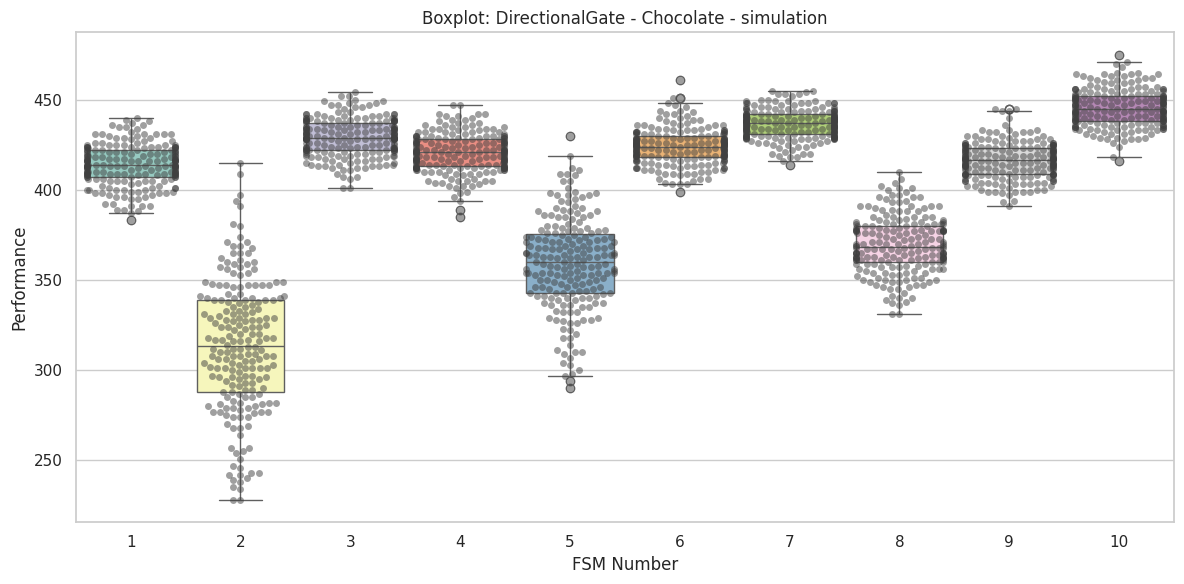

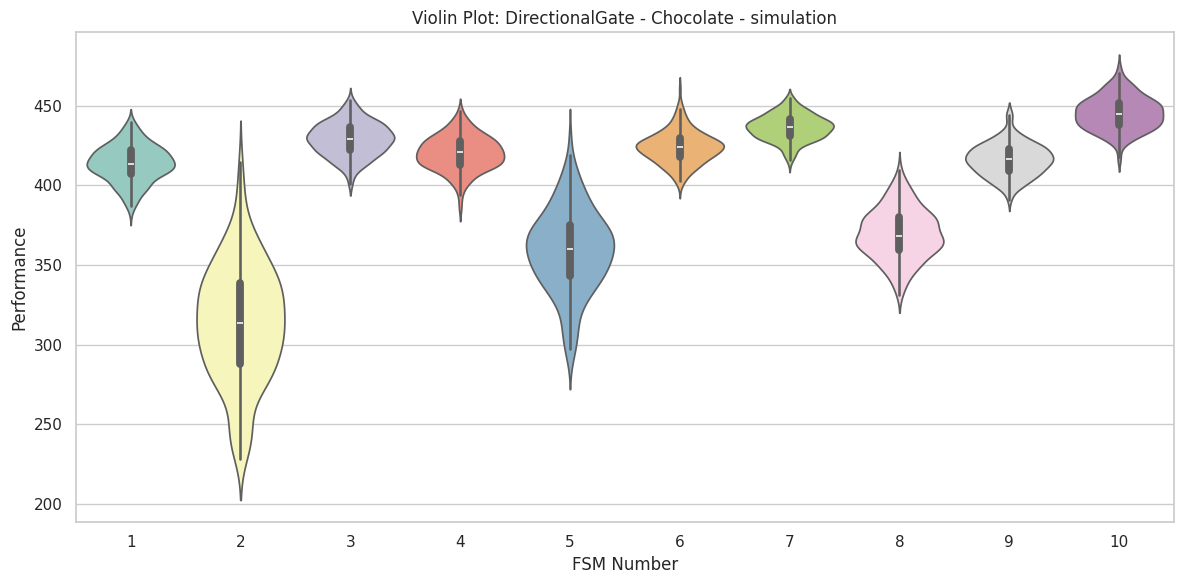

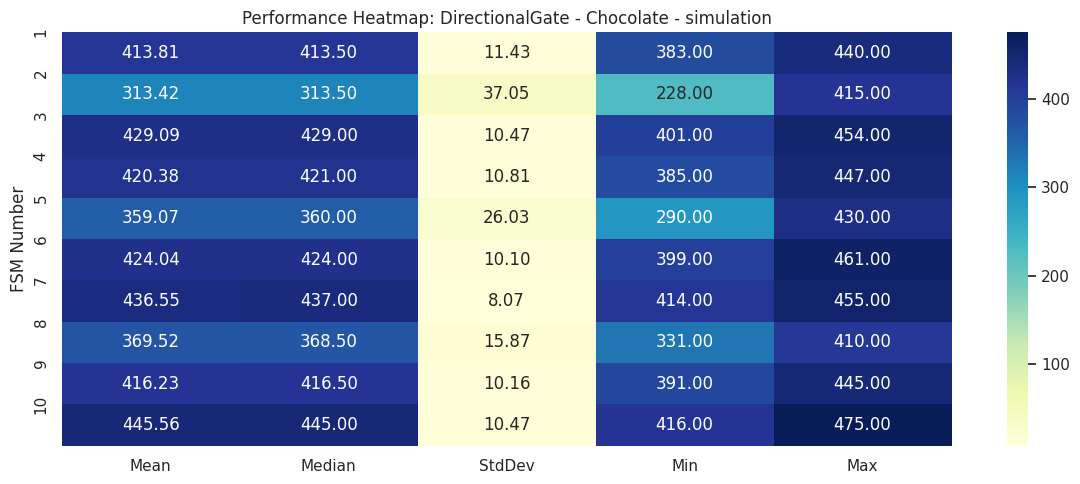

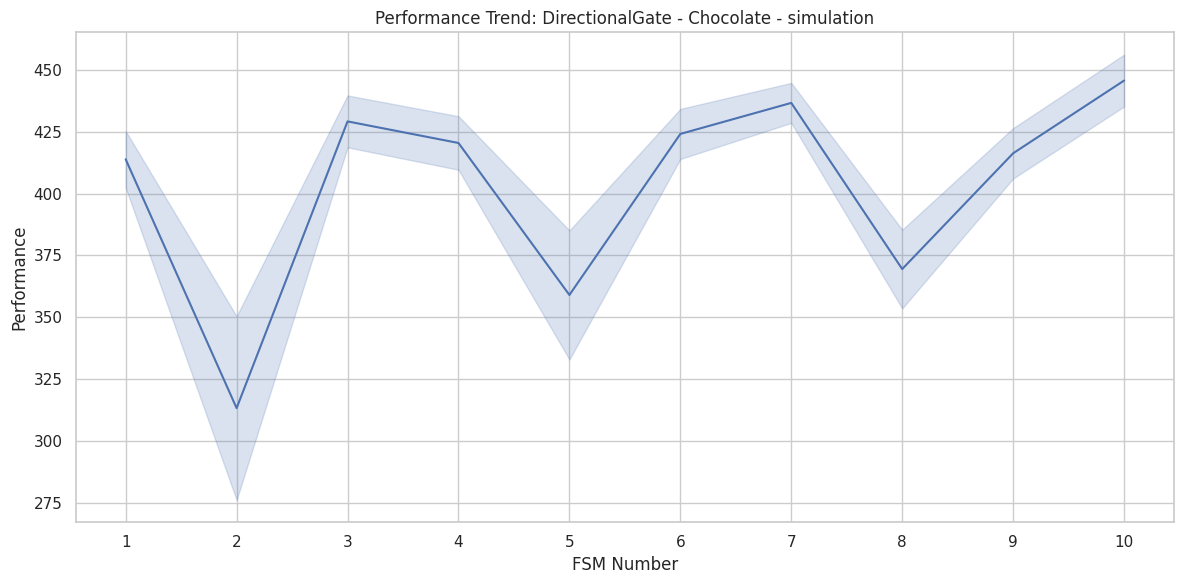

## Statistical Analysis Summary for DirectionalGate - Chocolate - simulation

### Descriptive Statistics with Rankings

,FSM,Mean,StdDev,Median,Rank_Mean,Rank_Median,PostHoc_Score,Rank_PostHoc,Aggregate_Rank
0,--nstates 2 --s0 0 --rwm0 1 --n0 2 --n0x0 0 --...,413.805,11.428035,413.5,7.0,7.0,3,6.0,20.0
1,--nstates 2 --s0 0 --rwm0 1 --n0 2 --n0x0 0 --...,313.415,37.053171,313.5,10.0,10.0,0,10.0,30.0
2,--nstates 2 --s0 0 --rwm0 1 --n0 4 --n0x0 0 --...,429.090,10.472357,429.0,3.0,3.0,7,3.0,9.0
3,--nstates 2 --s0 2 --n0 2 --n0x0 0 --c0x0 1 --...,420.385,10.805581,421.0,5.0,5.0,5,5.0,15.0
4,--nstates 3 --s0 0 --rwm0 1 --n0 2 --n0x0 0 --...,359.070,26.028301,360.0,9.0,9.0,1,9.0,27.0
5,--nstates 3 --s0 0 --rwm0 2 --n0 2 --n0x0 0 --...,424.035,10.102180,424.0,4.0,4.0,6,4.0,12.0
6,--nstates 3 --s0 0 --rwm0 3 --n0 4 --n0x0 0 --...,436.550,8.069267,437.0,2.0,2.0,8,2.0,6.0
7,--nstates 3 --s0 0 --rwm0 85 --n0 3 --n0x0 0 -...,369.525,15.867522,368.5,8.0,8.0,2,8.0,24.0
8,--nstates 4 --s0 0 --rwm0 1 --n0 2 --n0x0 0 --...,416.230,10.160377,416.5,6.0,6.0,3,6.0,18.0
9,--nstates 4 --s0 0 --rwm0 87 --n0 3 --n0x0 0 -...,445.565,10.473982,445.0,1.0,1.0,9,1.0,3.0


### Normality Test (Shapiro-Wilk)

,FSM,W,p-value,Normality
0,--nstates 2 --s0 0 --rwm0 1 --n0 2 --n0x0 0 --...,0.992449,0.391962,Normal
1,--nstates 2 --s0 0 --rwm0 1 --n0 2 --n0x0 0 --...,0.993093,0.472514,Normal
2,--nstates 2 --s0 0 --rwm0 1 --n0 4 --n0x0 0 --...,0.994151,0.623125,Normal
3,--nstates 2 --s0 2 --n0 2 --n0x0 0 --c0x0 1 --...,0.993815,0.573414,Normal
4,--nstates 3 --s0 0 --rwm0 1 --n0 2 --n0x0 0 --...,0.993444,0.520319,Normal
5,--nstates 3 --s0 0 --rwm0 2 --n0 2 --n0x0 0 --...,0.987740,0.082373,Normal
6,--nstates 3 --s0 0 --rwm0 3 --n0 4 --n0x0 0 --...,0.993450,0.521254,Normal
7,--nstates 3 --s0 0 --rwm0 85 --n0 3 --n0x0 0 -...,0.994807,0.721468,Normal
8,--nstates 4 --s0 0 --rwm0 1 --n0 2 --n0x0 0 --...,0.991032,0.251503,Normal
9,--nstates 4 --s0 0 --rwm0 87 --n0 3 --n0x0 0 -...,0.995039,0.755737,Normal


### Homogeneity of Variance Test (Levene's Test)

Levene's Statistic: 99.7288, p-value: 6.1382e-154 (Unequal Variances)


### ANOVA/Kruskal-Wallis Results

Non-parametric test performed.

### Effect Size

Not applicable


### Post-hoc Analysis

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,FSM,--nstates 2 --s0 0 --rwm0 1 --n0 2 --n0x0 0 --...,--nstates 2 --s0 0 --rwm0 1 --n0 2 --n0x0 0 --...,False,True,36.614097,398.0,two-sided,1.718869e-129,7.734912e-128,bonferroni,2.253e+125,3.654506
1,FSM,--nstates 2 --s0 0 --rwm0 1 --n0 2 --n0x0 0 --...,--nstates 2 --s0 0 --rwm0 1 --n0 4 --n0x0 0 --...,False,True,-13.945384,398.0,two-sided,2.864292e-36,1.288932e-34,bonferroni,6.892e+32,-1.391909
2,FSM,--nstates 2 --s0 0 --rwm0 1 --n0 2 --n0x0 0 --...,--nstates 2 --s0 2 --n0 2 --n0x0 0 --c0x0 1 --...,False,True,-5.916647,398.0,two-sided,7.089633e-09,3.190335e-07,bonferroni,1.346e+06,-0.590549
3,FSM,--nstates 2 --s0 0 --rwm0 1 --n0 2 --n0x0 0 --...,--nstates 3 --s0 0 --rwm0 1 --n0 2 --n0x0 0 --...,False,True,27.230460,398.0,two-sided,6.097937e-93,2.744072e-91,bonferroni,9.84e+88,2.717911
4,FSM,--nstates 2 --s0 0 --rwm0 1 --n0 2 --n0x0 0 --...,--nstates 3 --s0 0 --rwm0 2 --n0 2 --n0x0 0 --...,False,True,-9.484957,398.0,two-sided,2.247490e-19,1.011371e-17,bonferroni,1.85e+16,-0.946707
5,FSM,--nstates 2 --s0 0 --rwm0 1 --n0 2 --n0x0 0 --...,--nstates 3 --s0 0 --rwm0 3 --n0 4 --n0x0 0 --...,False,True,-22.992757,398.0,two-sided,4.805166e-75,2.162325e-73,bonferroni,1.646e+71,-2.294940
6,FSM,--nstates 2 --s0 0 --rwm0 1 --n0 2 --n0x0 0 --...,--nstates 3 --s0 0 --rwm0 85 --n0 3 --n0x0 0 -...,False,True,32.024033,398.0,two-sided,3.378778e-112,1.520450e-110,bonferroni,1.388e+108,3.196365
7,FSM,--nstates 2 --s0 0 --rwm0 1 --n0 2 --n0x0 0 --...,--nstates 4 --s0 0 --rwm0 1 --n0 2 --n0x0 0 --...,False,True,-2.242713,398.0,two-sided,2.546514e-02,1.000000e+00,bonferroni,1.241,-0.223848
8,FSM,--nstates 2 --s0 0 --rwm0 1 --n0 2 --n0x0 0 --...,--nstates 4 --s0 0 --rwm0 87 --n0 3 --n0x0 0 -...,False,True,-28.974420,398.0,two-sided,4.410841e-100,1.984879e-98,bonferroni,1.235e+96,-2.891979
9,FSM,--nstates 2 --s0 0 --rwm0 1 --n0 2 --n0x0 0 --...,--nstates 2 --s0 0 --rwm0 1 --n0 4 --n0x0 0 --...,False,True,-42.485563,398.0,two-sided,5.763632e-150,2.593634e-148,bonferroni,5.5e+145,-4.240545


### Best FSM based on Aggregate Rank: --nstates 4 --s0 0 --rwm0 87 --n0 3 --n0x0 0 --c0x0 4 --p0x0 8 --w0x0 1.8 --n0x1 1 --c0x1 0 --p0x1 0.89 --n0x2 0 --c0x2 2 --p0x2 0.11 --s1 0 --rwm1 35 --n1 4 --n1x0 1 --c1x0 2 --p1x0 0.58 --n1x1 0 --c1x1 4 --p1x1 9 --w1x1 17.08 --n1x2 1 --c1x2 0 --p1x2 0.49 --n1x3 2 --c1x3 2 --p1x3 0.58 --s2 2 --n2 3 --n2x0 1 --c2x0 1 --p2x0 0.14 --n2x1 2 --c2x1 1 --p2x1 0.96 --n2x2 1 --c2x2 2 --p2x2 0.45 --s3 2 --n3 3 --n3x0 0 --c3x0 3 --p3x0 5 --w3x0 19.3 --n3x1 2 --c3x1 2 --p3x1 0.87 --n3x2 2 --c3x2 5 --p3x2 0.36

Aggregate Rank Details:
                                                 FSM  Aggregate_Rank
9  --nstates 4 --s0 0 --rwm0 87 --n0 3 --n0x0 0 -...             3.0
6  --nstates 3 --s0 0 --rwm0 3 --n0 4 --n0x0 0 --...             6.0
2  --nstates 2 --s0 0 --rwm0 1 --n0 4 --n0x0 0 --...             9.0
5  --nstates 3 --s0 0 --rwm0 2 --n0 2 --n0x0 0 --...            12.0
3  --nstates 2 --s0 2 --n0 2 --n0x0 0 --c0x0 1 --...            15.0
8  --nstates 4 --s0 0 --rwm0 1 --n0 2 --n0x0 0 --...            18.0
0  --nstates 2 --s0 0 --rwm0 1 --n0 2 --n0x0 0 --...            20.0
7  --nstates 3 --s0 0 --rwm0 85 --n0 3 --n0x0 0 -...            24.0
4  --nstates 3 --s0 0 --rwm0 1 --n0 2 --n0x0 0 --...            27.0
1  --nstates 2 --s0 0 --rwm0 1 --n0 2 --n0x0 0 --...            30.0

# Analyzing Foraging - Chocolate - simulation

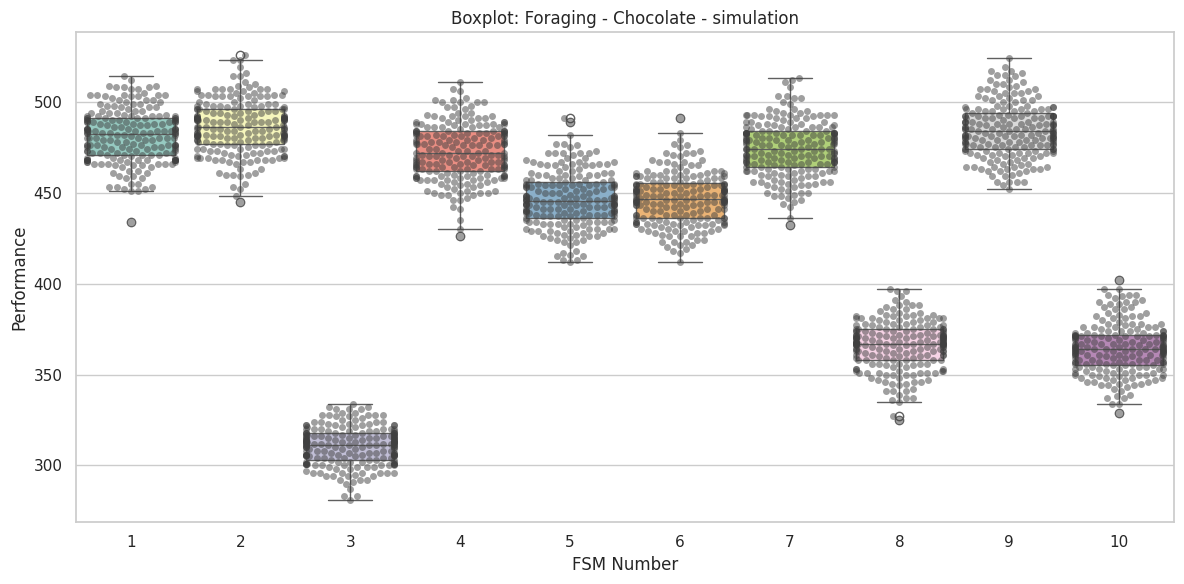

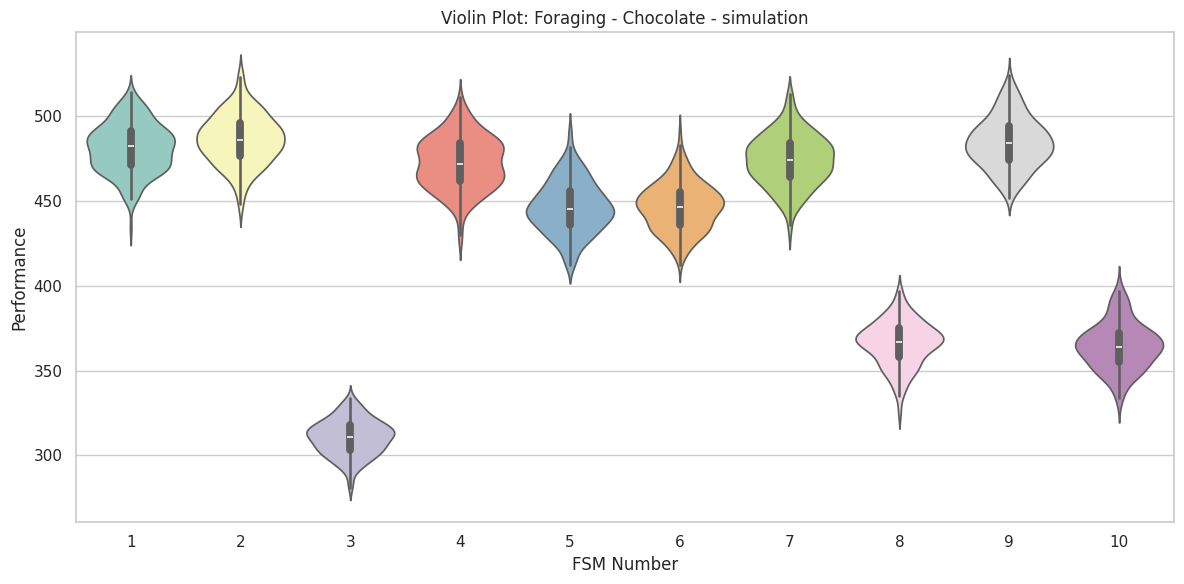

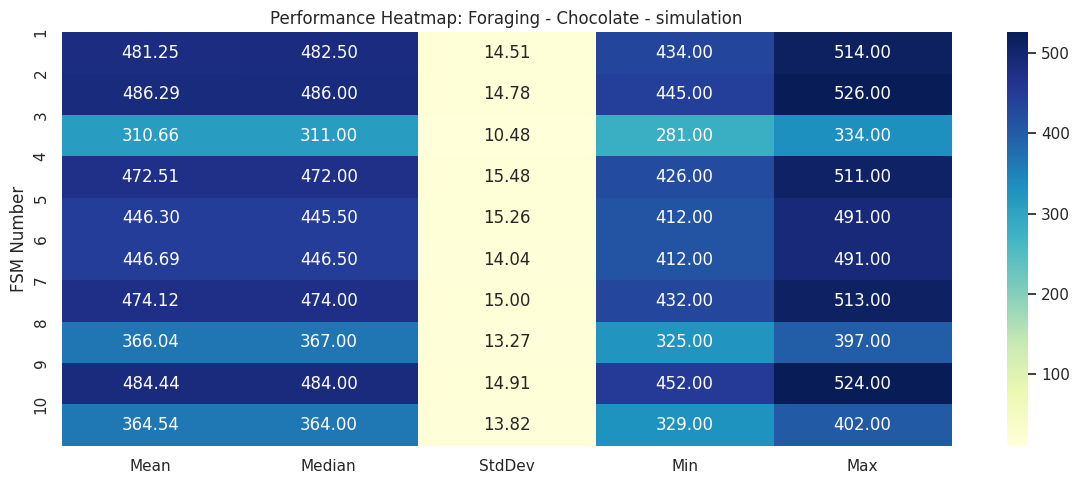

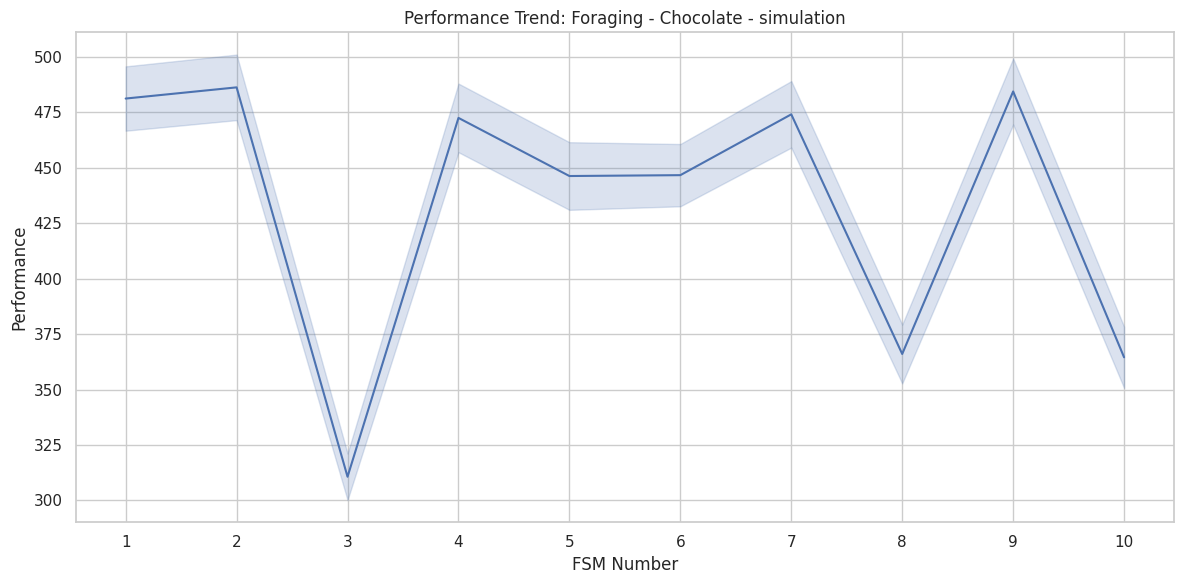

## Statistical Analysis Summary for Foraging - Chocolate - simulation

### Descriptive Statistics with Rankings

,FSM,Mean,StdDev,Median,Rank_Mean,Rank_Median,PostHoc_Score,Rank_PostHoc,Aggregate_Rank
0,--nstates 3 --s0 0 --rwm0 2 --n0 4 --n0x0 1 --...,481.245,14.513033,482.5,3.0,3.0,7,2.0,8.0
1,--nstates 3 --s0 2 --n0 2 --n0x0 0 --c0x0 2 --...,486.290,14.776591,486.0,1.0,1.0,8,1.0,3.0
2,--nstates 4 --s0 0 --rwm0 16 --n0 1 --n0x0 0 -...,310.660,10.478233,311.0,10.0,10.0,0,10.0,30.0
3,--nstates 4 --s0 0 --rwm0 3 --n0 3 --n0x0 0 --...,472.515,15.480244,472.0,5.0,5.0,5,4.0,14.0
4,--nstates 4 --s0 0 --rwm0 30 --n0 3 --n0x0 0 -...,446.300,15.259893,445.5,7.0,7.0,3,6.0,20.0
5,--nstates 4 --s0 0 --rwm0 5 --n0 2 --n0x0 0 --...,446.690,14.043504,446.5,6.0,6.0,3,6.0,18.0
6,--nstates 4 --s0 0 --rwm0 56 --n0 1 --n0x0 0 -...,474.120,15.002365,474.0,4.0,4.0,5,4.0,12.0
7,--nstates 4 --s0 0 --rwm0 81 --n0 3 --n0x0 0 -...,366.035,13.270429,367.0,8.0,8.0,1,8.0,24.0
8,--nstates 4 --s0 3 --n0 1 --n0x0 0 --c0x0 4 --...,484.440,14.906961,484.0,2.0,2.0,7,2.0,6.0
9,--nstates 4 --s0 4 --att0 2.27 --n0 3 --n0x0 0...,364.540,13.817126,364.0,9.0,9.0,1,8.0,26.0


### Normality Test (Shapiro-Wilk)

,FSM,W,p-value,Normality
0,--nstates 3 --s0 0 --rwm0 2 --n0 4 --n0x0 1 --...,0.990862,0.237961,Normal
1,--nstates 3 --s0 2 --n0 2 --n0x0 0 --c0x0 2 --...,0.996306,0.914811,Normal
2,--nstates 4 --s0 0 --rwm0 16 --n0 1 --n0x0 0 -...,0.992446,0.391707,Normal
3,--nstates 4 --s0 0 --rwm0 3 --n0 3 --n0x0 0 --...,0.992927,0.450858,Normal
4,--nstates 4 --s0 0 --rwm0 30 --n0 3 --n0x0 0 -...,0.992949,0.453666,Normal
5,--nstates 4 --s0 0 --rwm0 5 --n0 2 --n0x0 0 --...,0.994801,0.720550,Normal
6,--nstates 4 --s0 0 --rwm0 56 --n0 1 --n0x0 0 -...,0.996559,0.937530,Normal
7,--nstates 4 --s0 0 --rwm0 81 --n0 3 --n0x0 0 -...,0.987197,0.068258,Normal
8,--nstates 4 --s0 3 --n0 1 --n0x0 0 --c0x0 4 --...,0.990291,0.196981,Normal
9,--nstates 4 --s0 4 --att0 2.27 --n0 3 --n0x0 0...,0.992273,0.371758,Normal


### Homogeneity of Variance Test (Levene's Test)

Levene's Statistic: 4.2933, p-value: 1.5167e-05 (Unequal Variances)


### ANOVA/Kruskal-Wallis Results

Non-parametric test performed.

### Effect Size

Not applicable


### Post-hoc Analysis

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,FSM,--nstates 3 --s0 0 --rwm0 2 --n0 4 --n0x0 1 --...,--nstates 3 --s0 2 --n0 2 --n0x0 0 --c0x0 2 --...,False,True,-3.444767,398.0,two-sided,6.323287e-04,2.845479e-02,bonferroni,31.879,-0.343827
1,FSM,--nstates 3 --s0 0 --rwm0 2 --n0 4 --n0x0 1 --...,--nstates 4 --s0 0 --rwm0 16 --n0 1 --n0x0 0 -...,False,True,134.770558,398.0,two-sided,0.000000e+00,0.000000e+00,bonferroni,inf,13.451643
2,FSM,--nstates 3 --s0 0 --rwm0 2 --n0 4 --n0x0 1 --...,--nstates 4 --s0 0 --rwm0 3 --n0 3 --n0x0 0 --...,False,True,5.818280,398.0,two-sided,1.223650e-08,5.506423e-07,bonferroni,8.007e+05,0.580731
3,FSM,--nstates 3 --s0 0 --rwm0 2 --n0 4 --n0x0 1 --...,--nstates 4 --s0 0 --rwm0 30 --n0 3 --n0x0 0 -...,False,True,23.466965,398.0,two-sided,4.438861e-77,1.997487e-75,bonferroni,1.721e+73,2.342272
4,FSM,--nstates 3 --s0 0 --rwm0 2 --n0 4 --n0x0 1 --...,--nstates 4 --s0 0 --rwm0 5 --n0 2 --n0x0 0 --...,False,True,24.197844,398.0,two-sided,3.350509e-80,1.507729e-78,bonferroni,2.167e+76,2.415222
5,FSM,--nstates 3 --s0 0 --rwm0 2 --n0 4 --n0x0 1 --...,--nstates 4 --s0 0 --rwm0 56 --n0 1 --n0x0 0 -...,False,True,4.827325,398.0,two-sided,1.976162e-06,8.892728e-05,bonferroni,6568.612,0.481822
6,FSM,--nstates 3 --s0 0 --rwm0 2 --n0 4 --n0x0 1 --...,--nstates 4 --s0 0 --rwm0 81 --n0 3 --n0x0 0 -...,False,True,82.851407,398.0,two-sided,4.327208e-253,1.947244e-251,bonferroni,3.32e+248,8.269518
7,FSM,--nstates 3 --s0 0 --rwm0 2 --n0 4 --n0x0 1 --...,--nstates 4 --s0 3 --n0 1 --n0x0 0 --c0x0 4 --...,False,True,-2.171798,398.0,two-sided,3.046084e-02,1.000000e+00,bonferroni,1.069,-0.216770
8,FSM,--nstates 3 --s0 0 --rwm0 2 --n0 4 --n0x0 1 --...,--nstates 4 --s0 4 --att0 2.27 --n0 3 --n0x0 0...,False,True,82.364387,398.0,two-sided,3.974072e-252,1.788333e-250,bonferroni,3.639e+247,8.220908
9,FSM,--nstates 3 --s0 2 --n0 2 --n0x0 0 --c0x0 2 --...,--nstates 4 --s0 0 --rwm0 16 --n0 1 --n0x0 0 -...,False,True,137.114520,398.0,two-sided,0.000000e+00,0.000000e+00,bonferroni,inf,13.685598


### Best FSM based on Aggregate Rank: --nstates 3 --s0 2 --n0 2 --n0x0 0 --c0x0 2 --p0x0 0.67 --n0x1 0 --c0x1 2 --p0x1 0.88 --s1 3 --n1 4 --n1x0 0 --c1x0 1 --p1x0 0.07 --n1x1 1 --c1x1 1 --p1x1 0.46 --n1x2 1 --c1x2 0 --p1x2 0.93 --n1x3 1 --c1x3 0 --p1x3 0.06 --s2 0 --rwm2 3 --n2 2 --n2x0 0 --c2x0 0 --p2x0 0.98 --n2x1 0 --c2x1 2 --p2x1 0.55

Aggregate Rank Details:
                                                 FSM  Aggregate_Rank
1  --nstates 3 --s0 2 --n0 2 --n0x0 0 --c0x0 2 --...             3.0
8  --nstates 4 --s0 3 --n0 1 --n0x0 0 --c0x0 4 --...             6.0
0  --nstates 3 --s0 0 --rwm0 2 --n0 4 --n0x0 1 --...             8.0
6  --nstates 4 --s0 0 --rwm0 56 --n0 1 --n0x0 0 -...            12.0
3  --nstates 4 --s0 0 --rwm0 3 --n0 3 --n0x0 0 --...            14.0
5  --nstates 4 --s0 0 --rwm0 5 --n0 2 --n0x0 0 --...            18.0
4  --nstates 4 --s0 0 --rwm0 30 --n0 3 --n0x0 0 -...            20.0
7  --nstates 4 --s0 0 --rwm0 81 --n0 3 --n0x0 0 -...            24.0
9  --nstates 4 --s0 4 --att0 2.27 --n0 3 --n0x0 0...            26.0
2  --nstates 4 --s0 0 --rwm0 16 --n0 1 --n0x0 0 -...            30.0

# Analyzing Homing - Chocolate - simulation

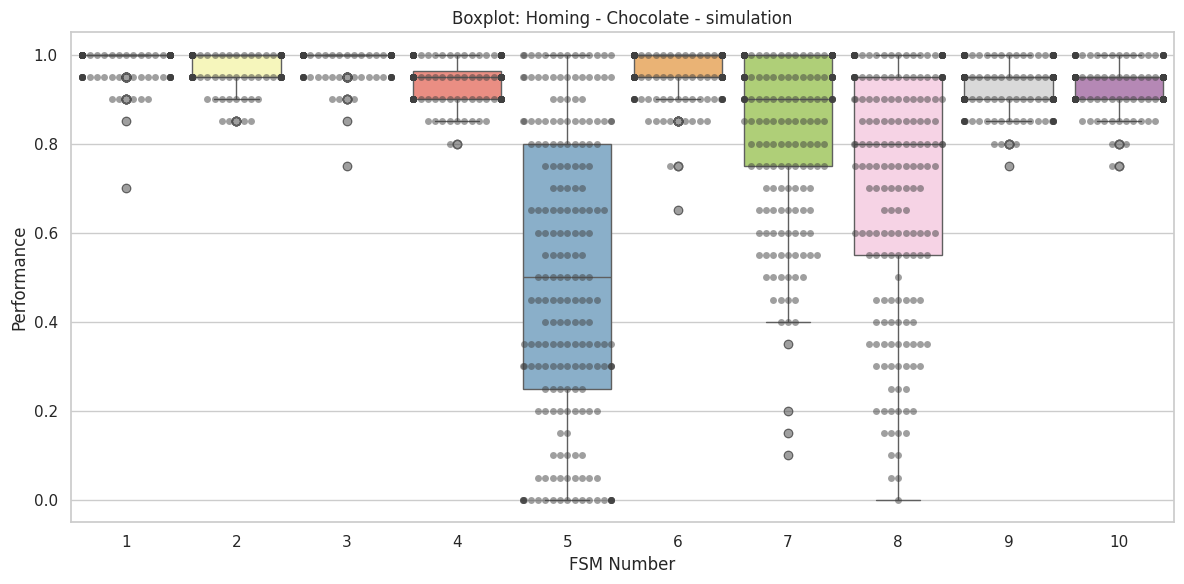

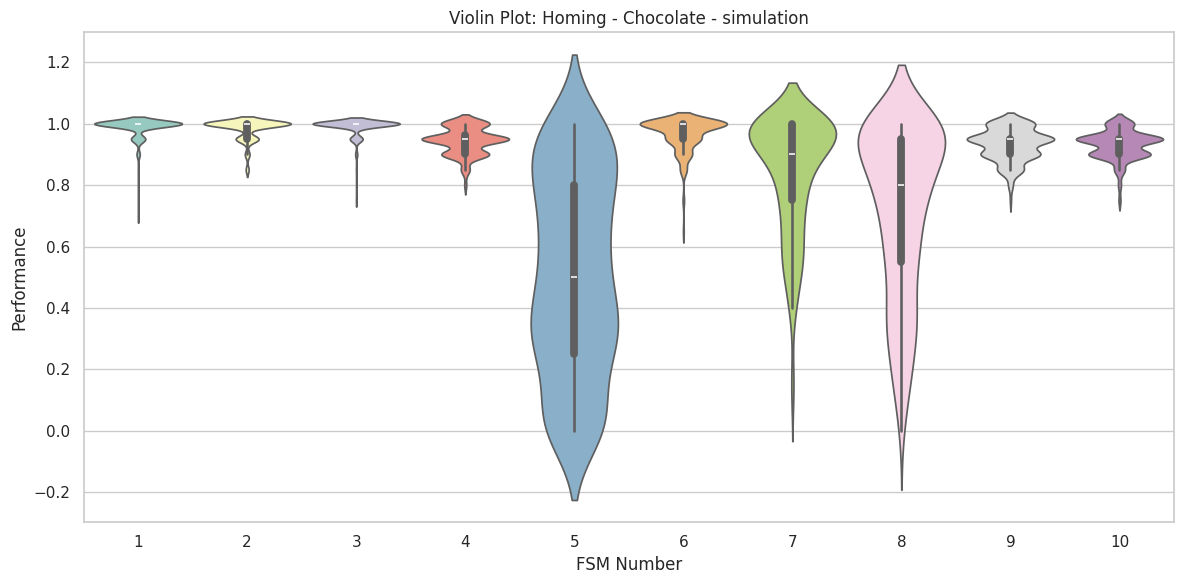

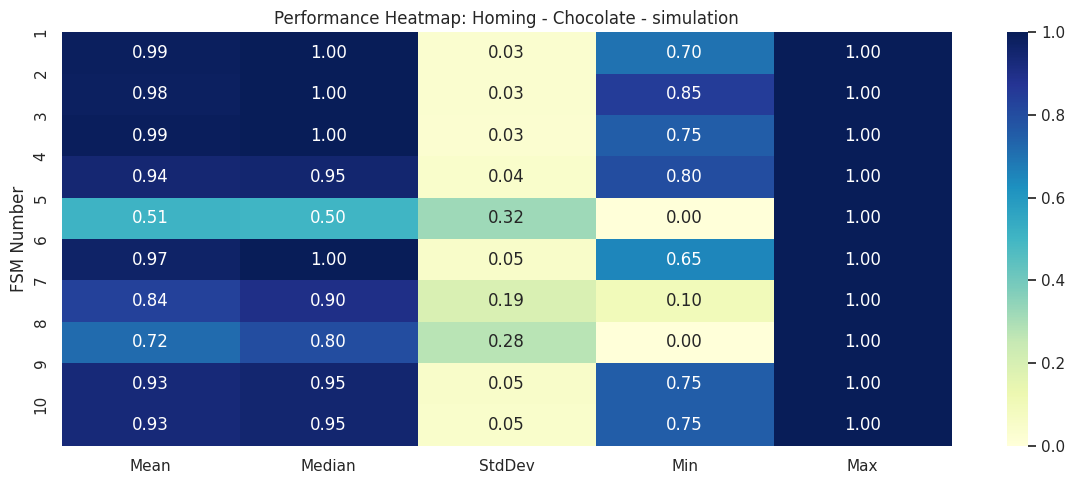

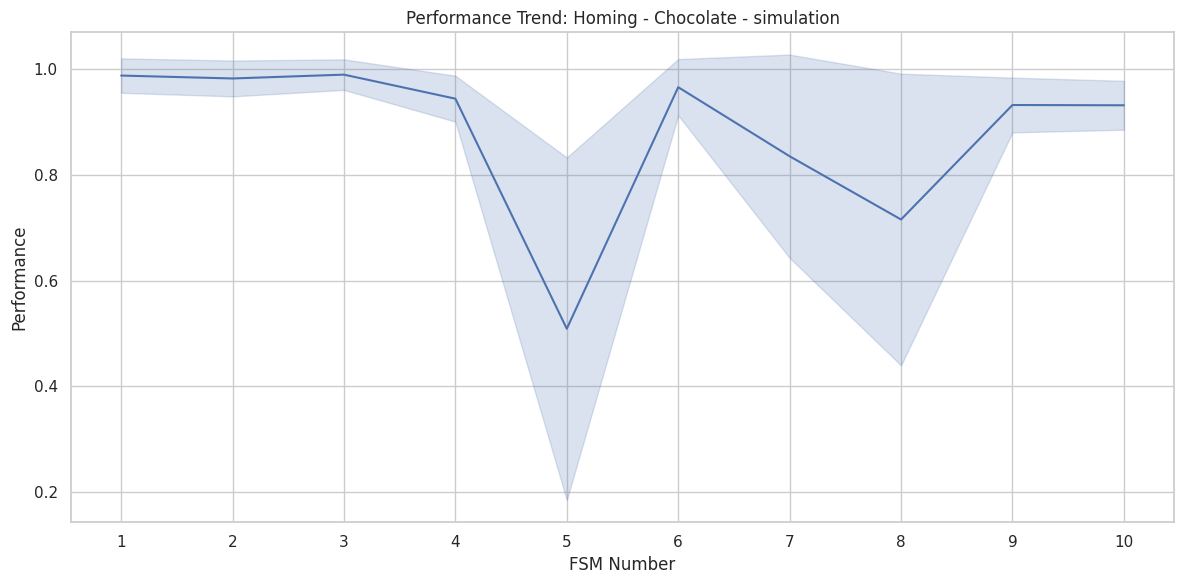

## Statistical Analysis Summary for Homing - Chocolate - simulation

### Descriptive Statistics with Rankings

,FSM,Mean,StdDev,Median,Rank_Mean,Rank_Median,PostHoc_Score,Rank_PostHoc,Aggregate_Rank
0,--nstates 3 --s0 0 --rwm0 1 --n0 2 --n0x0 0 -...,0.98800,0.032578,1.00,2.0,1.0,7,1.0,4.0
1,--nstates 3 --s0 0 --rwm0 2 --n0 2 --n0x0 0 -...,0.98250,0.033904,1.00,3.0,1.0,7,1.0,5.0
2,--nstates 3 --s0 0 --rwm0 2 --n0 2 --n0x0 1 -...,0.98975,0.028924,1.00,1.0,1.0,7,1.0,3.0
3,--nstates 3 --s0 0 --rwm0 69 --n0 2 --n0x0 1 ...,0.94425,0.043461,0.95,5.0,5.0,3,5.0,15.0
4,--nstates 4 --s0 0 --rwm0 1 --n0 1 --n0x0 1 -...,0.50875,0.324209,0.50,10.0,10.0,0,10.0,30.0
5,--nstates 4 --s0 0 --rwm0 1 --n0 1 --n0x0 1 -...,0.96600,0.053227,1.00,4.0,1.0,6,4.0,9.0
6,--nstates 4 --s0 0 --rwm0 1 --n0 2 --n0x0 1 -...,0.83525,0.192432,0.90,8.0,8.0,2,8.0,24.0
7,--nstates 4 --s0 0 --rwm0 10 --n0 3 --n0x0 2 ...,0.71550,0.276118,0.80,9.0,9.0,1,9.0,27.0
8,--nstates 4 --s0 0 --rwm0 23 --n0 2 --n0x0 0 ...,0.93225,0.051825,0.95,6.0,5.0,3,5.0,16.0
9,--nstates 4 --s0 0 --rwm0 63 --n0 4 --n0x0 0 ...,0.93175,0.046262,0.95,7.0,5.0,3,5.0,17.0


### Normality Test (Shapiro-Wilk)

,FSM,W,p-value,Normality
0,--nstates 3 --s0 0 --rwm0 1 --n0 2 --n0x0 0 -...,0.408451,3.234011e-25,Not Normal
1,--nstates 3 --s0 0 --rwm0 2 --n0 2 --n0x0 0 -...,0.567859,4.587909e-22,Not Normal
2,--nstates 3 --s0 0 --rwm0 2 --n0 2 --n0x0 1 -...,0.395730,1.941037e-25,Not Normal
3,--nstates 3 --s0 0 --rwm0 69 --n0 2 --n0x0 1 ...,0.858997,1.201093e-12,Not Normal
4,--nstates 4 --s0 0 --rwm0 1 --n0 1 --n0x0 1 -...,0.934057,7.192198e-08,Not Normal
5,--nstates 4 --s0 0 --rwm0 1 --n0 1 --n0x0 1 -...,0.671612,1.713021e-19,Not Normal
6,--nstates 4 --s0 0 --rwm0 1 --n0 2 --n0x0 1 -...,0.820021,1.859844e-14,Not Normal
7,--nstates 4 --s0 0 --rwm0 10 --n0 3 --n0x0 2 ...,0.878819,1.366167e-11,Not Normal
8,--nstates 4 --s0 0 --rwm0 23 --n0 2 --n0x0 0 ...,0.888045,4.643688e-11,Not Normal
9,--nstates 4 --s0 0 --rwm0 63 --n0 4 --n0x0 0 ...,0.855492,8.008635e-13,Not Normal


### Homogeneity of Variance Test (Levene's Test)

Levene's Statistic: 219.2987, p-value: 4.1847e-290 (Unequal Variances)


### ANOVA/Kruskal-Wallis Results

Non-parametric test performed.

### Effect Size

Not applicable


### Post-hoc Analysis

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,FSM,--nstates 3 --s0 0 --rwm0 1 --n0 2 --n0x0 0 -...,--nstates 3 --s0 0 --rwm0 2 --n0 2 --n0x0 0 -...,False,True,1.654255,398.0,two-sided,9.886402e-02,1.000000e+00,bonferroni,0.414,0.165114
1,FSM,--nstates 3 --s0 0 --rwm0 1 --n0 2 --n0x0 0 -...,--nstates 3 --s0 0 --rwm0 2 --n0 2 --n0x0 1 -...,False,True,-0.568085,398.0,two-sided,5.702976e-01,1.000000e+00,bonferroni,0.129,-0.056701
2,FSM,--nstates 3 --s0 0 --rwm0 1 --n0 2 --n0x0 0 -...,--nstates 3 --s0 0 --rwm0 69 --n0 2 --n0x0 1 ...,False,True,11.391166,398.0,two-sided,3.274909e-26,1.473709e-24,bonferroni,8.929e+22,1.136969
3,FSM,--nstates 3 --s0 0 --rwm0 1 --n0 2 --n0x0 0 -...,--nstates 4 --s0 0 --rwm0 1 --n0 1 --n0x0 1 -...,False,True,20.800342,398.0,two-sided,1.427141e-65,6.422135e-64,bonferroni,6.585e+61,2.076112
4,FSM,--nstates 3 --s0 0 --rwm0 1 --n0 2 --n0x0 0 -...,--nstates 4 --s0 0 --rwm0 1 --n0 1 --n0x0 1 -...,False,True,4.985553,398.0,two-sided,9.239808e-07,4.157913e-05,bonferroni,1.341e+04,0.497615
5,FSM,--nstates 3 --s0 0 --rwm0 1 --n0 2 --n0x0 0 -...,--nstates 4 --s0 0 --rwm0 1 --n0 2 --n0x0 1 -...,False,True,11.068347,398.0,two-sided,5.248352e-25,2.361758e-23,bonferroni,5.891e+21,1.104748
6,FSM,--nstates 3 --s0 0 --rwm0 1 --n0 2 --n0x0 0 -...,--nstates 4 --s0 0 --rwm0 10 --n0 3 --n0x0 2 ...,False,True,13.860708,398.0,two-sided,6.351973e-36,2.858388e-34,bonferroni,3.145e+32,1.383457
7,FSM,--nstates 3 --s0 0 --rwm0 1 --n0 2 --n0x0 0 -...,--nstates 4 --s0 0 --rwm0 23 --n0 2 --n0x0 0 ...,False,True,12.879766,398.0,two-sided,5.677320e-32,2.554794e-30,bonferroni,4.057e+28,1.285548
8,FSM,--nstates 3 --s0 0 --rwm0 1 --n0 2 --n0x0 0 -...,--nstates 4 --s0 0 --rwm0 63 --n0 4 --n0x0 0 ...,False,True,14.059327,398.0,two-sided,9.782912e-37,4.402310e-35,bonferroni,1.987e+33,1.403282
9,FSM,--nstates 3 --s0 0 --rwm0 2 --n0 2 --n0x0 0 -...,--nstates 3 --s0 0 --rwm0 2 --n0 2 --n0x0 1 -...,False,True,-2.300650,398.0,two-sided,2.192777e-02,9.867495e-01,bonferroni,1.408,-0.229631


### Best FSM based on Aggregate Rank:  --nstates 3 --s0 0 --rwm0 2 --n0 2 --n0x0 1 --c0x0 0 --p0x0 0.59 --n0x1 1 --c0x1 0 --p0x1 0.13 --s1 1 --n1 1 --n1x0 1 --c1x0 1 --p1x0 0.73 --s2 4 --att2 4.69 --n2 2 --n2x0 1 --c2x0 4 --p2x0 1 --w2x0 5.52 --n2x1 1 --c2x1 3 --p2x1 1 --w2x1 3.15

Aggregate Rank Details:
                                                 FSM  Aggregate_Rank
2   --nstates 3 --s0 0 --rwm0 2 --n0 2 --n0x0 1 -...             3.0
0   --nstates 3 --s0 0 --rwm0 1 --n0 2 --n0x0 0 -...             4.0
1   --nstates 3 --s0 0 --rwm0 2 --n0 2 --n0x0 0 -...             5.0
5   --nstates 4 --s0 0 --rwm0 1 --n0 1 --n0x0 1 -...             9.0
3   --nstates 3 --s0 0 --rwm0 69 --n0 2 --n0x0 1 ...            15.0
8   --nstates 4 --s0 0 --rwm0 23 --n0 2 --n0x0 0 ...            16.0
9   --nstates 4 --s0 0 --rwm0 63 --n0 4 --n0x0 0 ...            17.0
6   --nstates 4 --s0 0 --rwm0 1 --n0 2 --n0x0 1 -...            24.0
7   --nstates 4 --s0 0 --rwm0 10 --n0 3 --n0x0 2 ...            27.0
4   --nstates 4 --s0 0 --rwm0 1 --n0 1 --n0x0 1 -...            30.0

# Analyzing Shelter - Chocolate - simulation

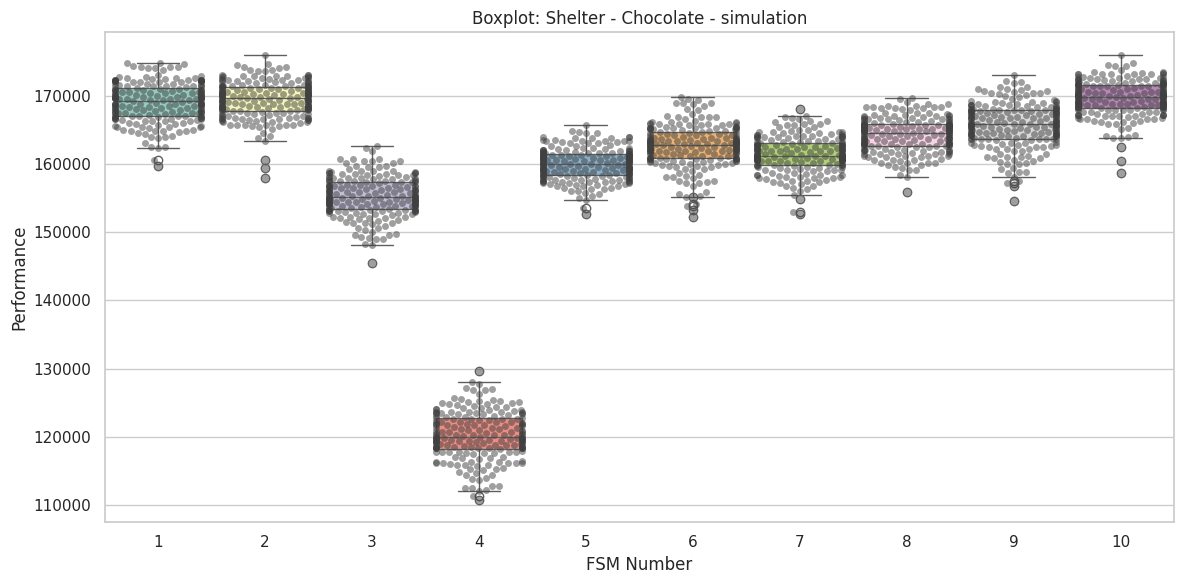

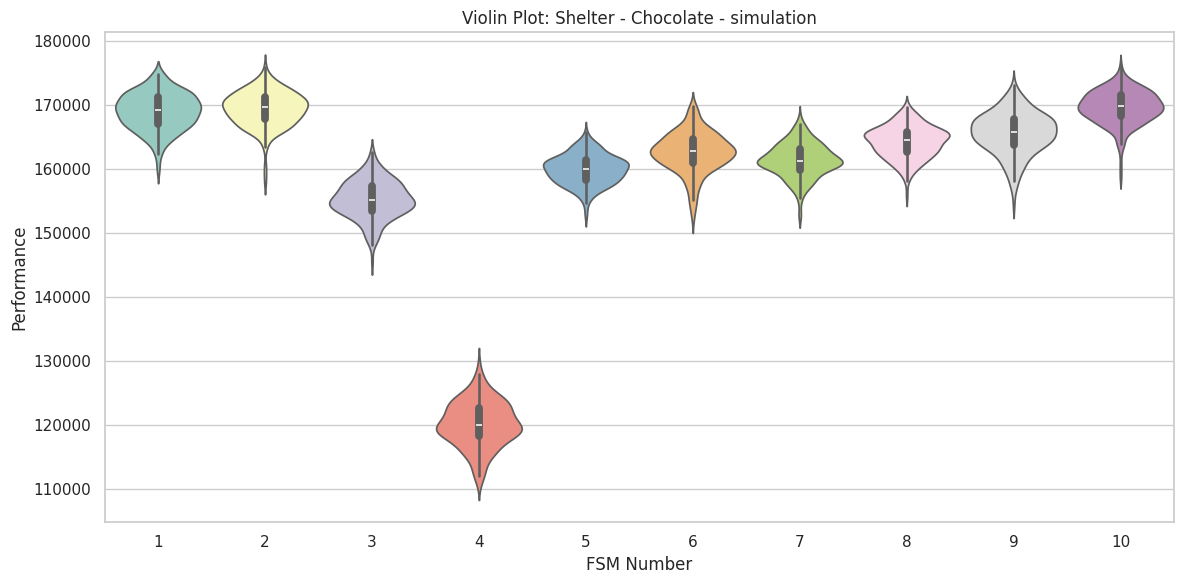

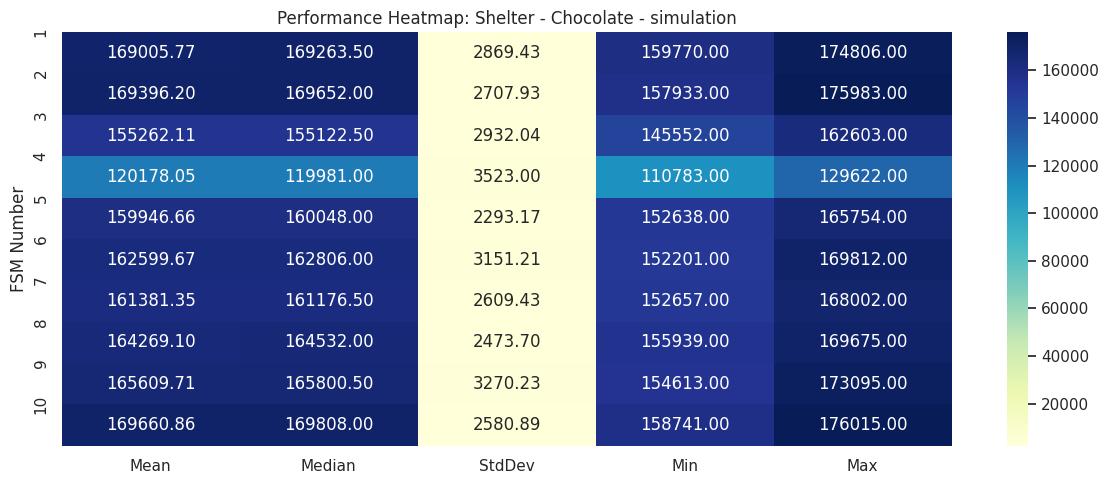

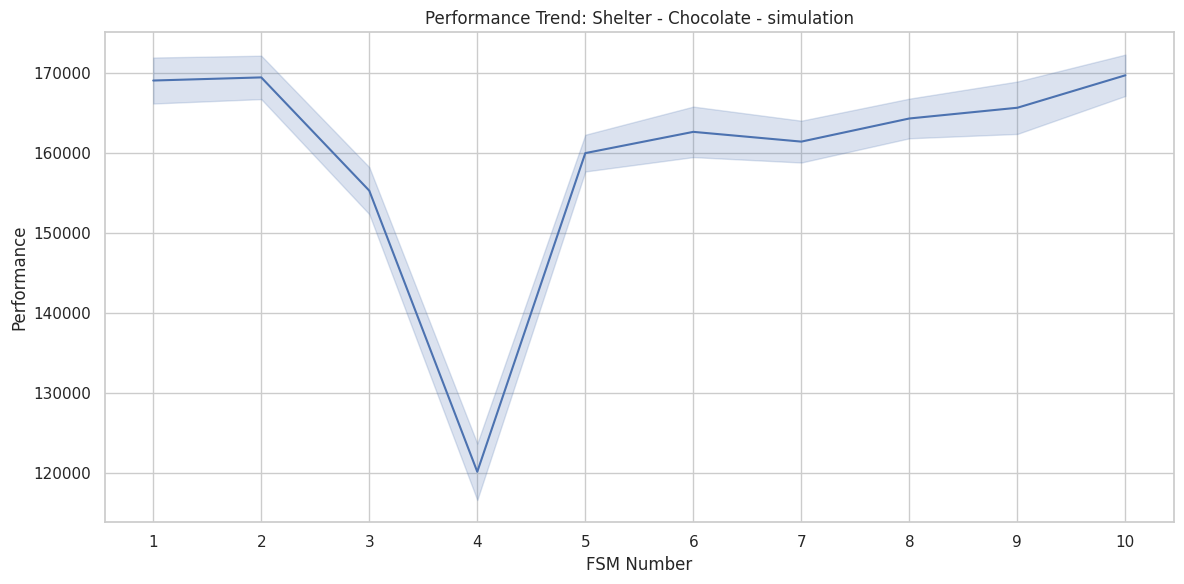

## Statistical Analysis Summary for Shelter - Chocolate - simulation

### Descriptive Statistics with Rankings

,FSM,Mean,StdDev,Median,Rank_Mean,Rank_Median,PostHoc_Score,Rank_PostHoc,Aggregate_Rank
0,--nstates 2 --s0 2 --n0 1 --n0x0 0 --c0x0 3 -...,169005.770,2869.425441,169263.5,3.0,3.0,7,1.0,7.0
1,--nstates 2 --s0 2 --n0 1 --n0x0 0 --c0x0 3 -...,169396.205,2707.925935,169652.0,2.0,2.0,7,1.0,5.0
2,--nstates 2 --s0 2 --n0 3 --n0x0 0 --c0x0 2 -...,155262.115,2932.037502,155122.5,9.0,9.0,1,9.0,27.0
3,--nstates 2 --s0 3 --n0 1 --n0x0 0 --c0x0 1 -...,120178.055,3522.997384,119981.0,10.0,10.0,0,10.0,30.0
4,--nstates 2 --s0 3 --n0 3 --n0x0 0 --c0x0 5 -...,159946.660,2293.170440,160048.0,8.0,8.0,2,8.0,24.0
5,--nstates 3 --s0 2 --n0 2 --n0x0 0 --c0x0 3 -...,162599.665,3151.213017,162806.0,6.0,6.0,4,6.0,18.0
6,--nstates 3 --s0 2 --n0 2 --n0x0 1 --c0x0 3 -...,161381.345,2609.429090,161176.5,7.0,7.0,3,7.0,21.0
7,--nstates 4 --s0 2 --n0 1 --n0x0 2 --c0x0 3 -...,164269.100,2473.696240,164532.0,5.0,5.0,5,5.0,15.0
8,--nstates 4 --s0 2 --n0 4 --n0x0 2 --c0x0 3 -...,165609.715,3270.228753,165800.5,4.0,4.0,6,4.0,12.0
9,--nstates 4 --s0 4 --att0 3.59 --n0 4 --n0x0 ...,169660.860,2580.887372,169808.0,1.0,1.0,7,1.0,3.0


### Normality Test (Shapiro-Wilk)

,FSM,W,p-value,Normality
0,--nstates 2 --s0 2 --n0 1 --n0x0 0 --c0x0 3 -...,0.987020,0.064193,Normal
1,--nstates 2 --s0 2 --n0 1 --n0x0 0 --c0x0 3 -...,0.968467,0.000183,Not Normal
2,--nstates 2 --s0 2 --n0 3 --n0x0 0 --c0x0 2 -...,0.994261,0.639559,Normal
3,--nstates 2 --s0 3 --n0 1 --n0x0 0 --c0x0 1 -...,0.994333,0.650302,Normal
4,--nstates 2 --s0 3 --n0 3 --n0x0 0 --c0x0 5 -...,0.995514,0.822292,Normal
5,--nstates 3 --s0 2 --n0 2 --n0x0 0 --c0x0 3 -...,0.977610,0.002761,Not Normal
6,--nstates 3 --s0 2 --n0 2 --n0x0 1 --c0x0 3 -...,0.988979,0.126314,Normal
7,--nstates 4 --s0 2 --n0 1 --n0x0 2 --c0x0 3 -...,0.989793,0.166636,Normal
8,--nstates 4 --s0 2 --n0 4 --n0x0 2 --c0x0 3 -...,0.985352,0.036035,Not Normal
9,--nstates 4 --s0 4 --att0 3.59 --n0 4 --n0x0 ...,0.971324,0.000413,Not Normal


### Homogeneity of Variance Test (Levene's Test)

Levene's Statistic: 5.5791, p-value: 1.2393e-07 (Unequal Variances)


### ANOVA/Kruskal-Wallis Results

Non-parametric test performed.

### Effect Size

Not applicable


### Post-hoc Analysis

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,FSM,--nstates 2 --s0 2 --n0 1 --n0x0 0 --c0x0 3 -...,--nstates 2 --s0 2 --n0 1 --n0x0 0 --c0x0 3 -...,False,True,-1.399487,398.0,two-sided,1.624460e-01,1.000000e+00,bonferroni,0.285,-0.139685
1,FSM,--nstates 2 --s0 2 --n0 1 --n0x0 0 --c0x0 3 -...,--nstates 2 --s0 2 --n0 3 --n0x0 0 --c0x0 2 -...,False,True,47.377204,398.0,two-sided,1.070223e-165,4.816001e-164,bonferroni,2.575e+161,4.728787
2,FSM,--nstates 2 --s0 2 --n0 1 --n0x0 0 --c0x0 3 -...,--nstates 2 --s0 3 --n0 1 --n0x0 0 --c0x0 1 -...,False,True,151.975215,398.0,two-sided,0.000000e+00,0.000000e+00,bonferroni,inf,15.168865
3,FSM,--nstates 2 --s0 2 --n0 1 --n0x0 0 --c0x0 3 -...,--nstates 2 --s0 3 --n0 3 --n0x0 0 --c0x0 5 -...,False,True,34.878565,398.0,two-sided,4.357387e-123,1.960824e-121,bonferroni,9.515e+118,3.481280
4,FSM,--nstates 2 --s0 2 --n0 1 --n0x0 0 --c0x0 3 -...,--nstates 3 --s0 2 --n0 2 --n0x0 0 --c0x0 3 -...,False,True,21.257214,398.0,two-sided,1.491473e-67,6.711630e-66,bonferroni,6.066e+63,2.121713
5,FSM,--nstates 2 --s0 2 --n0 1 --n0x0 0 --c0x0 3 -...,--nstates 3 --s0 2 --n0 2 --n0x0 1 --c0x0 3 -...,False,True,27.800901,398.0,two-sided,2.712616e-95,1.220677e-93,bonferroni,2.141e+91,2.774848
6,FSM,--nstates 2 --s0 2 --n0 1 --n0x0 0 --c0x0 3 -...,--nstates 4 --s0 2 --n0 1 --n0x0 2 --c0x0 3 -...,False,True,17.681544,398.0,two-sided,4.758555e-52,2.141350e-50,bonferroni,2.646e+48,1.764820
7,FSM,--nstates 2 --s0 2 --n0 1 --n0x0 0 --c0x0 3 -...,--nstates 4 --s0 2 --n0 4 --n0x0 2 --c0x0 3 -...,False,True,11.039194,398.0,two-sided,6.729164e-25,3.028124e-23,bonferroni,4.618e+21,1.101838
8,FSM,--nstates 2 --s0 2 --n0 1 --n0x0 0 --c0x0 3 -...,--nstates 4 --s0 4 --att0 3.59 --n0 4 --n0x0 ...,False,True,-2.400501,398.0,two-sided,1.683099e-02,7.573947e-01,bonferroni,1.762,-0.239597
9,FSM,--nstates 2 --s0 2 --n0 1 --n0x0 0 --c0x0 3 -...,--nstates 2 --s0 2 --n0 3 --n0x0 0 --c0x0 2 -...,False,True,50.081688,398.0,two-sided,6.444983e-174,2.900242e-172,bonferroni,3.99e+169,4.998725


### Best FSM based on Aggregate Rank:  --nstates 4 --s0 4 --att0 3.59 --n0 4 --n0x0 0 --c0x0 5 --p0x0 0.23 --n0x1 0 --c0x1 4 --p0x1 4 --w0x1 0.87 --n0x2 2 --c0x2 2 --p0x2 0.27 --n0x3 2 --c0x3 4 --p0x3 4 --w0x3 14.69 --s1 2 --n1 3 --n1x0 2 --c1x0 2 --p1x0 0.87 --n1x1 1 --c1x1 3 --p1x1 8 --w1x1 15.03 --n1x2 1 --c1x2 3 --p1x2 3 --w1x2 8.5 --s2 3 --n2 4 --n2x0 1 --c2x0 0 --p2x0 0.92 --n2x1 0 --c2x1 1 --p2x1 0.02 --n2x2 0 --c2x2 3 --p2x2 8 --w2x2 9.52 --n2x3 2 --c2x3 0 --p2x3 0.07 --s3 0 --rwm3 52 --n3 3 --n3x0 1 --c3x0 5 --p3x0 0.69 --n3x1 0 --c3x1 5 --p3x1 0.64 --n3x2 2 --c3x2 4 --p3x2 10 --w3x2 10.64

Aggregate Rank Details:
                                                 FSM  Aggregate_Rank
9   --nstates 4 --s0 4 --att0 3.59 --n0 4 --n0x0 ...             3.0
1   --nstates 2 --s0 2 --n0 1 --n0x0 0 --c0x0 3 -...             5.0
0   --nstates 2 --s0 2 --n0 1 --n0x0 0 --c0x0 3 -...             7.0
8   --nstates 4 --s0 2 --n0 4 --n0x0 2 --c0x0 3 -...            12.0
7   --nstates 4 --s0 2 --n0 1 --n0x0 2 --c0x0 3 -...            15.0
5   --nstates 3 --s0 2 --n0 2 --n0x0 0 --c0x0 3 -...            18.0
6   --nstates 3 --s0 2 --n0 2 --n0x0 1 --c0x0 3 -...            21.0
4   --nstates 2 --s0 3 --n0 3 --n0x0 0 --c0x0 5 -...            24.0
2   --nstates 2 --s0 2 --n0 3 --n0x0 0 --c0x0 2 -...            27.0
3   --nstates 2 --s0 3 --n0 1 --n0x0 0 --c0x0 1 -...            30.0

# Analyzing XOR-Aggregation - Chocolate - simulation

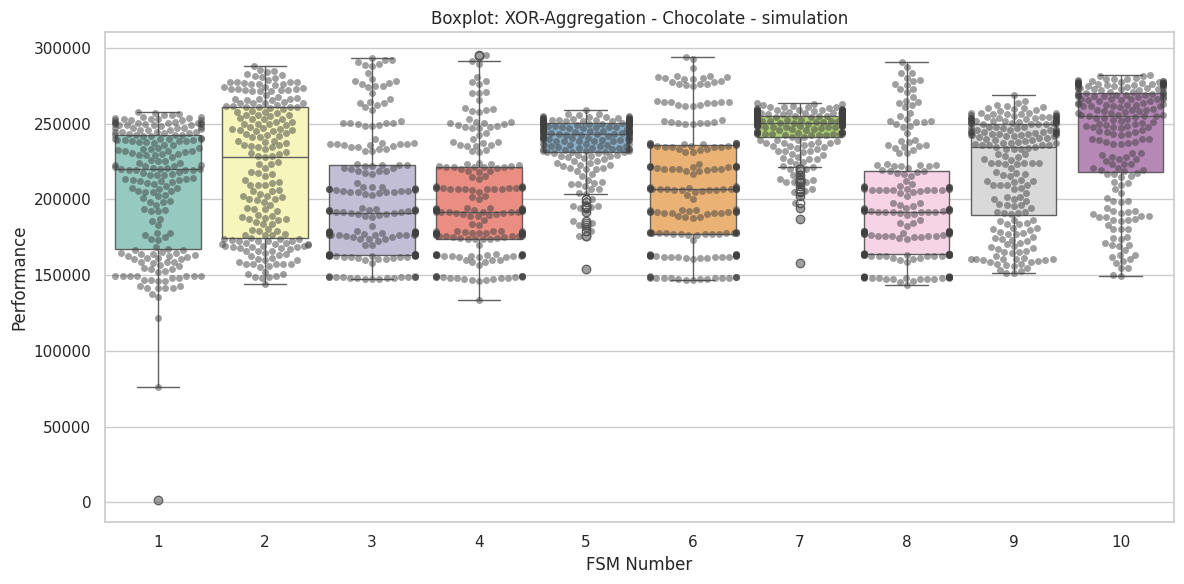

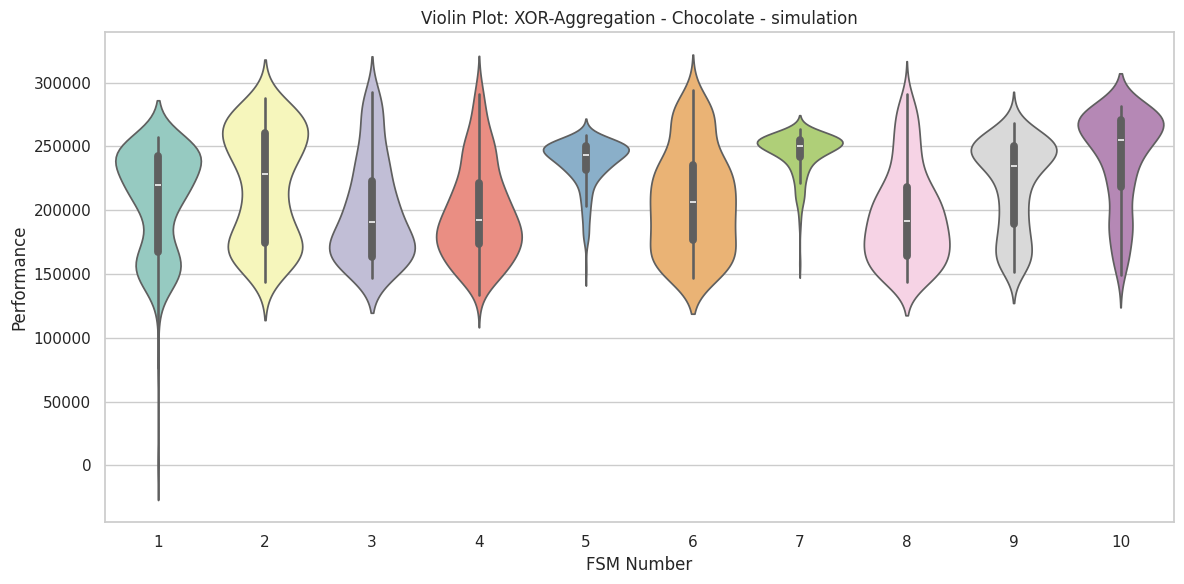

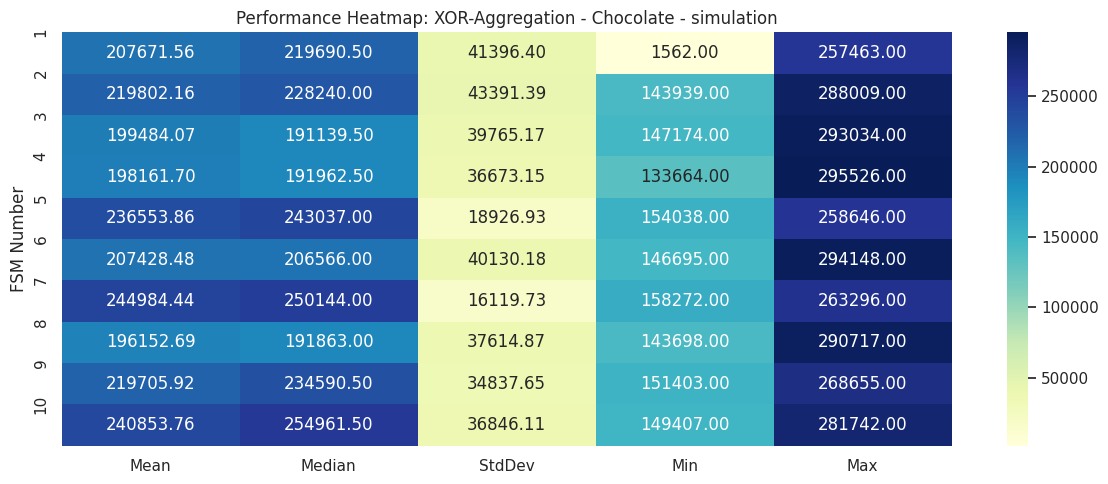

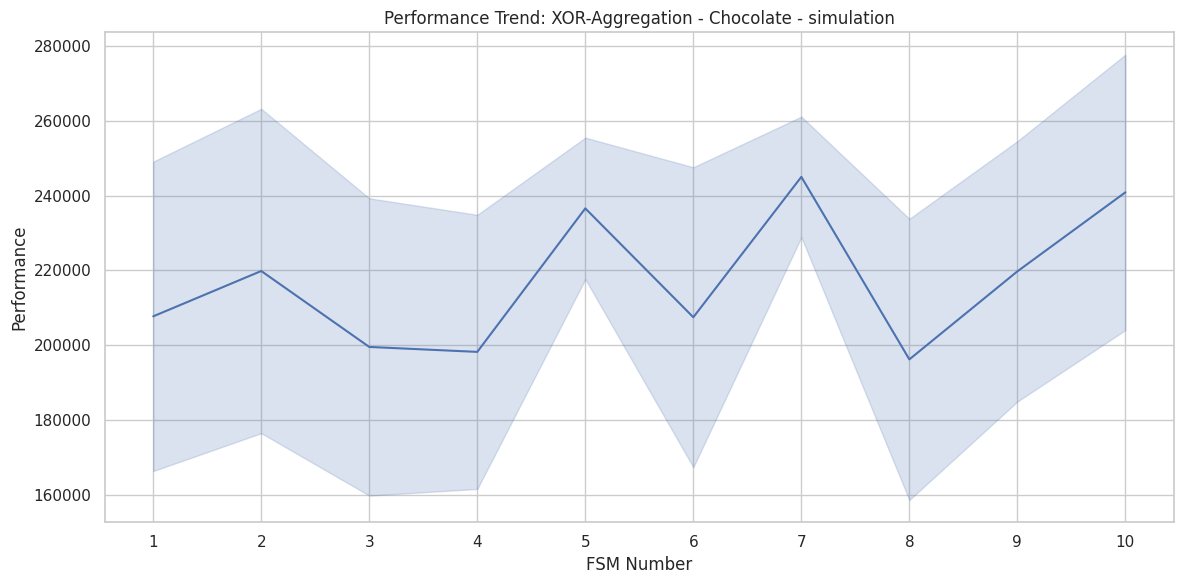

## Statistical Analysis Summary for XOR-Aggregation - Chocolate - simulation

### Descriptive Statistics with Rankings

,FSM,Mean,StdDev,Median,Rank_Mean,Rank_Median,PostHoc_Score,Rank_PostHoc,Aggregate_Rank
0,--nstates 2 --s0 4 --att0 4.34 --n0 4 --n0x0 0...,207671.560,41396.401630,219690.5,6.0,6.0,0,6.0,18.0
1,--nstates 3 --s0 1 --n0 1 --n0x0 1 --c0x0 1 --...,219802.160,43391.387298,228240.0,4.0,5.0,3,4.0,13.0
2,--nstates 3 --s0 4 --att0 4.08 --n0 4 --n0x0 0...,199484.070,39765.167526,191139.5,8.0,10.0,0,6.0,24.0
3,--nstates 3 --s0 4 --att0 4.55 --n0 1 --n0x0 1...,198161.705,36673.152758,191962.5,9.0,8.0,0,6.0,23.0
4,--nstates 4 --s0 0 --rwm0 2 --n0 3 --n0x0 1 --...,236553.865,18926.925393,243037.0,3.0,3.0,7,2.0,8.0
5,--nstates 4 --s0 0 --rwm0 34 --n0 3 --n0x0 1 -...,207428.475,40130.184646,206566.0,7.0,7.0,0,6.0,20.0
6,--nstates 4 --s0 0 --rwm0 60 --n0 3 --n0x0 2 -...,244984.440,16119.731058,250144.0,1.0,2.0,8,1.0,4.0
7,--nstates 4 --s0 0 --rwm0 66 --n0 3 --n0x0 1 -...,196152.690,37614.868948,191863.0,10.0,9.0,0,6.0,25.0
8,--nstates 4 --s0 1 --n0 1 --n0x0 1 --c0x0 1 --...,219705.915,34837.647619,234590.5,5.0,4.0,3,4.0,13.0
9,--nstates 4 --s0 4 --att0 4.4 --n0 4 --n0x0 1 ...,240853.760,36846.106971,254961.5,2.0,1.0,7,2.0,5.0


### Normality Test (Shapiro-Wilk)

,FSM,W,p-value,Normality
0,--nstates 2 --s0 4 --att0 4.34 --n0 4 --n0x0 0...,0.879772,1.545692e-11,Not Normal
1,--nstates 3 --s0 1 --n0 1 --n0x0 1 --c0x0 1 --...,0.916569,3.286259e-09,Not Normal
2,--nstates 3 --s0 4 --att0 4.08 --n0 4 --n0x0 0...,0.916574,3.288918e-09,Not Normal
3,--nstates 3 --s0 4 --att0 4.55 --n0 1 --n0x0 1...,0.948595,1.384508e-06,Not Normal
4,--nstates 4 --s0 0 --rwm0 2 --n0 3 --n0x0 1 --...,0.816079,1.265474e-14,Not Normal
5,--nstates 4 --s0 0 --rwm0 34 --n0 3 --n0x0 1 -...,0.952777,3.528020e-06,Not Normal
6,--nstates 4 --s0 0 --rwm0 60 --n0 3 --n0x0 2 -...,0.807908,5.802882e-15,Not Normal
7,--nstates 4 --s0 0 --rwm0 66 --n0 3 --n0x0 1 -...,0.932694,5.561293e-08,Not Normal
8,--nstates 4 --s0 1 --n0 1 --n0x0 1 --c0x0 1 --...,0.881552,1.949828e-11,Not Normal
9,--nstates 4 --s0 4 --att0 4.4 --n0 4 --n0x0 1 ...,0.865938,2.736275e-12,Not Normal


### Homogeneity of Variance Test (Levene's Test)

Levene's Statistic: 31.8606, p-value: 1.3254e-52 (Unequal Variances)


### ANOVA/Kruskal-Wallis Results

Non-parametric test performed.

### Effect Size

Not applicable


### Post-hoc Analysis

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,FSM,--nstates 2 --s0 4 --att0 4.34 --n0 4 --n0x0 0...,--nstates 3 --s0 1 --n0 1 --n0x0 1 --c0x0 1 --...,False,True,-2.860611,398.0,two-sided,4.451131e-03,2.003009e-01,bonferroni,5.578,-0.285522
1,FSM,--nstates 2 --s0 4 --att0 4.34 --n0 4 --n0x0 0...,--nstates 3 --s0 4 --att0 4.08 --n0 4 --n0x0 0...,False,True,2.017171,398.0,two-sided,4.434860e-02,1.000000e+00,bonferroni,0.784,0.201337
2,FSM,--nstates 2 --s0 4 --att0 4.34 --n0 4 --n0x0 0...,--nstates 3 --s0 4 --att0 4.55 --n0 1 --n0x0 1...,False,True,2.431805,398.0,two-sided,1.546406e-02,6.958828e-01,bonferroni,1.893,0.242722
3,FSM,--nstates 2 --s0 4 --att0 4.34 --n0 4 --n0x0 0...,--nstates 4 --s0 0 --rwm0 2 --n0 3 --n0x0 1 --...,False,True,-8.973533,398.0,two-sided,1.146416e-17,5.158871e-16,bonferroni,4.026e+14,-0.895661
4,FSM,--nstates 2 --s0 4 --att0 4.34 --n0 4 --n0x0 0...,--nstates 4 --s0 0 --rwm0 34 --n0 3 --n0x0 1 -...,False,True,0.059626,398.0,two-sided,9.524833e-01,1.000000e+00,bonferroni,0.111,0.005951
5,FSM,--nstates 2 --s0 4 --att0 4.34 --n0 4 --n0x0 0...,--nstates 4 --s0 0 --rwm0 60 --n0 3 --n0x0 2 -...,False,True,-11.878302,398.0,two-sided,4.626808e-28,2.082064e-26,bonferroni,5.826e+24,-1.185590
6,FSM,--nstates 2 --s0 4 --att0 4.34 --n0 4 --n0x0 0...,--nstates 4 --s0 0 --rwm0 66 --n0 3 --n0x0 1 -...,False,True,2.912420,398.0,two-sided,3.788409e-03,1.704784e-01,bonferroni,6.43,0.290693
7,FSM,--nstates 2 --s0 4 --att0 4.34 --n0 4 --n0x0 0...,--nstates 4 --s0 1 --n0 1 --n0x0 1 --c0x0 1 --...,False,True,-3.145592,398.0,two-sided,1.782036e-03,8.019161e-02,bonferroni,12.56,-0.313966
8,FSM,--nstates 2 --s0 4 --att0 4.34 --n0 4 --n0x0 0...,--nstates 4 --s0 4 --att0 4.4 --n0 4 --n0x0 1 ...,False,True,-8.467578,398.0,two-sided,4.880974e-16,2.196438e-14,bonferroni,1.053e+13,-0.845161
9,FSM,--nstates 3 --s0 1 --n0 1 --n0x0 1 --c0x0 1 --...,--nstates 3 --s0 4 --att0 4.08 --n0 4 --n0x0 0...,False,True,4.882068,398.0,two-sided,1.522576e-06,6.851594e-05,bonferroni,8388.442,0.487286


### Best FSM based on Aggregate Rank: --nstates 4 --s0 0 --rwm0 60 --n0 3 --n0x0 2 --c0x0 5 --p0x0 0.98 --n0x1 1 --c0x1 2 --p0x1 0.28 --n0x2 1 --c0x2 4 --p0x2 8 --w0x2 6.96 --s1 1 --n1 1 --n1x0 2 --c1x0 1 --p1x0 0.1 --s2 0 --rwm2 16 --n2 3 --n2x0 2 --c2x0 3 --p2x0 3 --w2x0 5.64 --n2x1 0 --c2x1 2 --p2x1 0.05 --n2x2 0 --c2x2 4 --p2x2 7 --w2x2 3.37 --s3 4 --att3 4.46 --n3 4 --n3x0 2 --c3x0 4 --p3x0 1 --w3x0 16.19 --n3x1 0 --c3x1 1 --p3x1 0.31 --n3x2 1 --c3x2 0 --p3x2 0.98 --n3x3 0 --c3x3 3 --p3x3 9 --w3x3 8.74

Aggregate Rank Details:
                                                 FSM  Aggregate_Rank
6  --nstates 4 --s0 0 --rwm0 60 --n0 3 --n0x0 2 -...             4.0
9  --nstates 4 --s0 4 --att0 4.4 --n0 4 --n0x0 1 ...             5.0
4  --nstates 4 --s0 0 --rwm0 2 --n0 3 --n0x0 1 --...             8.0
1  --nstates 3 --s0 1 --n0 1 --n0x0 1 --c0x0 1 --...            13.0
8  --nstates 4 --s0 1 --n0 1 --n0x0 1 --c0x0 1 --...            13.0
0  --nstates 2 --s0 4 --att0 4.34 --n0 4 --n0x0 0...            18.0
5  --nstates 4 --s0 0 --rwm0 34 --n0 3 --n0x0 1 -...            20.0
3  --nstates 3 --s0 4 --att0 4.55 --n0 1 --n0x0 1...            23.0
2  --nstates 3 --s0 4 --att0 4.08 --n0 4 --n0x0 0...            24.0
7  --nstates 4 --s0 0 --rwm0 66 --n0 3 --n0x0 1 -...            25.0

## Best FSMs for All Missions

,Best FSM
DirectionalGate_Chocolate_simulation,--nstates 4 --s0 0 --rwm0 87 --n0 3 --n0x0 0 -...
Foraging_Chocolate_simulation,--nstates 3 --s0 2 --n0 2 --n0x0 0 --c0x0 2 --...
Homing_Chocolate_simulation,--nstates 3 --s0 0 --rwm0 2 --n0 2 --n0x0 1 -...
Shelter_Chocolate_simulation,--nstates 4 --s0 4 --att0 3.59 --n0 4 --n0x0 ...
XOR-Aggregation_Chocolate_simulation,--nstates 4 --s0 0 --rwm0 60 --n0 3 --n0x0 2 -...


In [29]:
# Run the main analysis
best_fsms, all_fsm_mappings = main_analysis()

---
## FSM Mapping Reference

# FSM Mapping Reference

## DirectionalGate_Chocolate_simulation

,FSM,Number
0,--nstates 2 --s0 0 --rwm0 1 --n0 2 --n0x0 0 --...,1
1,--nstates 2 --s0 0 --rwm0 1 --n0 2 --n0x0 0 --...,2
2,--nstates 2 --s0 0 --rwm0 1 --n0 4 --n0x0 0 --...,3
3,--nstates 2 --s0 2 --n0 2 --n0x0 0 --c0x0 1 --...,4
4,--nstates 3 --s0 0 --rwm0 1 --n0 2 --n0x0 0 --...,5
5,--nstates 3 --s0 0 --rwm0 2 --n0 2 --n0x0 0 --...,6
6,--nstates 3 --s0 0 --rwm0 3 --n0 4 --n0x0 0 --...,7
7,--nstates 3 --s0 0 --rwm0 85 --n0 3 --n0x0 0 -...,8
8,--nstates 4 --s0 0 --rwm0 1 --n0 2 --n0x0 0 --...,9
9,--nstates 4 --s0 0 --rwm0 87 --n0 3 --n0x0 0 -...,10


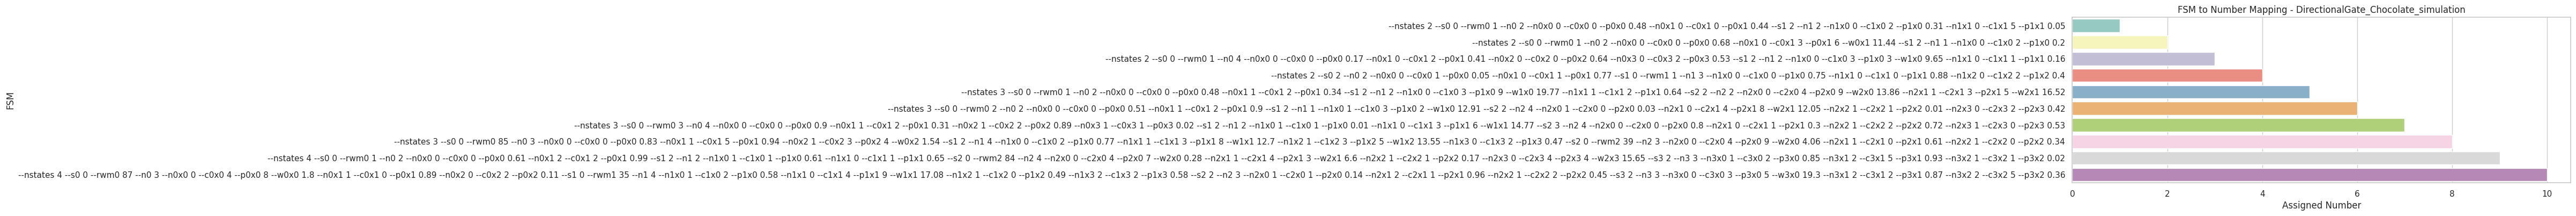

## Foraging_Chocolate_simulation

,FSM,Number
0,--nstates 3 --s0 0 --rwm0 2 --n0 4 --n0x0 1 --...,1
1,--nstates 3 --s0 2 --n0 2 --n0x0 0 --c0x0 2 --...,2
2,--nstates 4 --s0 0 --rwm0 16 --n0 1 --n0x0 0 -...,3
3,--nstates 4 --s0 0 --rwm0 3 --n0 3 --n0x0 0 --...,4
4,--nstates 4 --s0 0 --rwm0 30 --n0 3 --n0x0 0 -...,5
5,--nstates 4 --s0 0 --rwm0 5 --n0 2 --n0x0 0 --...,6
6,--nstates 4 --s0 0 --rwm0 56 --n0 1 --n0x0 0 -...,7
7,--nstates 4 --s0 0 --rwm0 81 --n0 3 --n0x0 0 -...,8
8,--nstates 4 --s0 3 --n0 1 --n0x0 0 --c0x0 4 --...,9
9,--nstates 4 --s0 4 --att0 2.27 --n0 3 --n0x0 0...,10


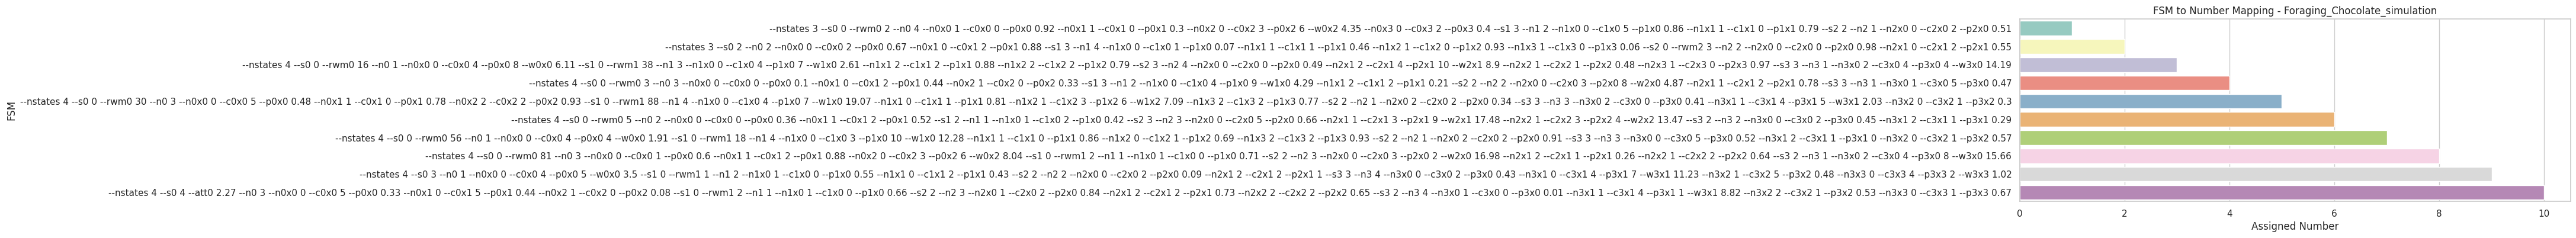

## Homing_Chocolate_simulation

,FSM,Number
0,--nstates 3 --s0 0 --rwm0 1 --n0 2 --n0x0 0 -...,1
1,--nstates 3 --s0 0 --rwm0 2 --n0 2 --n0x0 0 -...,2
2,--nstates 3 --s0 0 --rwm0 2 --n0 2 --n0x0 1 -...,3
3,--nstates 3 --s0 0 --rwm0 69 --n0 2 --n0x0 1 ...,4
4,--nstates 4 --s0 0 --rwm0 1 --n0 1 --n0x0 1 -...,5
5,--nstates 4 --s0 0 --rwm0 1 --n0 1 --n0x0 1 -...,6
6,--nstates 4 --s0 0 --rwm0 1 --n0 2 --n0x0 1 -...,7
7,--nstates 4 --s0 0 --rwm0 10 --n0 3 --n0x0 2 ...,8
8,--nstates 4 --s0 0 --rwm0 23 --n0 2 --n0x0 0 ...,9
9,--nstates 4 --s0 0 --rwm0 63 --n0 4 --n0x0 0 ...,10


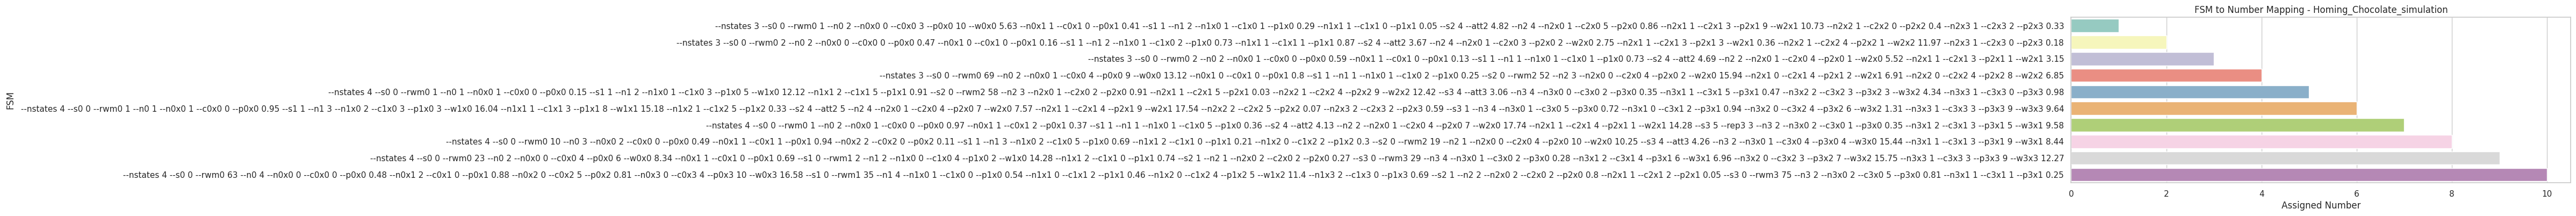

## Shelter_Chocolate_simulation

,FSM,Number
0,--nstates 2 --s0 2 --n0 1 --n0x0 0 --c0x0 3 -...,1
1,--nstates 2 --s0 2 --n0 1 --n0x0 0 --c0x0 3 -...,2
2,--nstates 2 --s0 2 --n0 3 --n0x0 0 --c0x0 2 -...,3
3,--nstates 2 --s0 3 --n0 1 --n0x0 0 --c0x0 1 -...,4
4,--nstates 2 --s0 3 --n0 3 --n0x0 0 --c0x0 5 -...,5
5,--nstates 3 --s0 2 --n0 2 --n0x0 0 --c0x0 3 -...,6
6,--nstates 3 --s0 2 --n0 2 --n0x0 1 --c0x0 3 -...,7
7,--nstates 4 --s0 2 --n0 1 --n0x0 2 --c0x0 3 -...,8
8,--nstates 4 --s0 2 --n0 4 --n0x0 2 --c0x0 3 -...,9
9,--nstates 4 --s0 4 --att0 3.59 --n0 4 --n0x0 ...,10


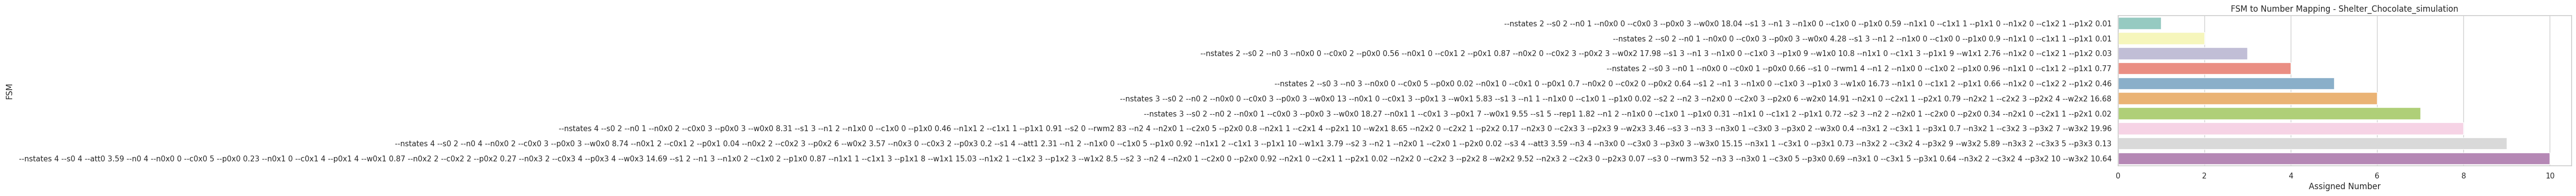

## XOR-Aggregation_Chocolate_simulation

,FSM,Number
0,--nstates 2 --s0 4 --att0 4.34 --n0 4 --n0x0 0...,1
1,--nstates 3 --s0 1 --n0 1 --n0x0 1 --c0x0 1 --...,2
2,--nstates 3 --s0 4 --att0 4.08 --n0 4 --n0x0 0...,3
3,--nstates 3 --s0 4 --att0 4.55 --n0 1 --n0x0 1...,4
4,--nstates 4 --s0 0 --rwm0 2 --n0 3 --n0x0 1 --...,5
5,--nstates 4 --s0 0 --rwm0 34 --n0 3 --n0x0 1 -...,6
6,--nstates 4 --s0 0 --rwm0 60 --n0 3 --n0x0 2 -...,7
7,--nstates 4 --s0 0 --rwm0 66 --n0 3 --n0x0 1 -...,8
8,--nstates 4 --s0 1 --n0 1 --n0x0 1 --c0x0 1 --...,9
9,--nstates 4 --s0 4 --att0 4.4 --n0 4 --n0x0 1 ...,10


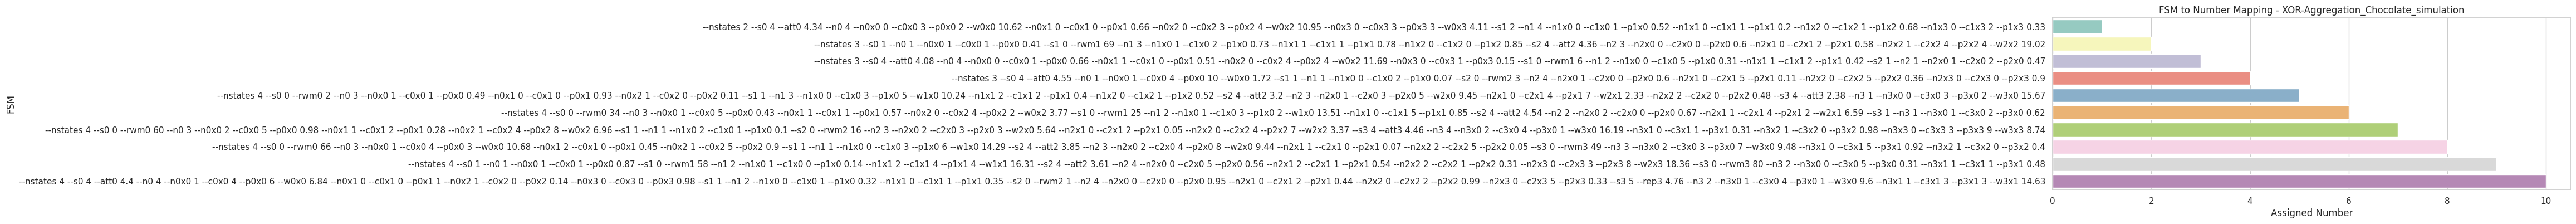

In [30]:
display(Markdown("# FSM Mapping Reference"))
for key, fsm_mapping in all_fsm_mappings.items():
    display(Markdown(f"## {key}"))
    fsm_mapping_df = pd.DataFrame(list(fsm_mapping.items()), columns=['FSM', 'Number'])
    fsm_mapping_df = fsm_mapping_df.sort_values('Number')
    display(fsm_mapping_df)

    # Plot FSM Mapping
    plt.figure(figsize=(12, len(fsm_mapping) * 0.4))
    sns.barplot(x='Number', y='FSM', data=fsm_mapping_df, palette='Set3')
    plt.title(f'FSM to Number Mapping - {key}')
    plt.xlabel('Assigned Number')
    plt.ylabel('FSM')
    plt.tight_layout()
    plt.show()
    save_plot(plt, f'fsm_mapping_{key}.png')